# Exploratory Text Analytics Final Project:
### Christian Literature from Protestant Reformation to the Present

* John Hazelton (Jch5nb@virginia.edu) 
* DS 5001
* December 17, 2021

## Analysis - using TFIDF, PCA, LDA, Word2vec

## Imports

In [858]:
# Stats & Analytics Packages:
import pandas as pd
import numpy as np
from numpy.linalg import norm
from glob import glob
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
from scipy.linalg import norm
from scipy.linalg import eigh
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
from gensim.models import word2vec
import gensim
from IPython.core.display import display, HTML

# Visualization Packages:
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks')
pio.renderers.default = 'notebook_connected'

## Load Tables 
(These were created in our 'data-organization' jupyter notebook)

In [660]:
OHCO = ['book_id', 'book_num', 'chap_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:5]
PARAS = OHCO[:4]
CHAPS = OHCO[:3]
BOOKS = OHCO[:1]

#data_dir = 'Input_Data/' # Or wherever you put your previous lab
DOC = pd.read_csv("DOC.csv").set_index(PARAS)
LIB = pd.read_csv("LIB.csv").set_index(BOOKS)
TOKEN = pd.read_csv('TOKEN.csv').set_index(OHCO)
VOCAB = pd.read_csv('VOCAB.csv').set_index('term_id')

## Return TFIDF Matrix using function
### Create TFIDF function:

In [662]:
def tfidf_matrix(token_df, bag, count_method, tf_method, idf_method):
    
    #Create Bag-of-Words:
    BOW_df = token_df.groupby(bag+['term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})
    BOW_df['c'] = BOW_df.n.astype('bool').astype('int')
    
    #Create Document Term-Count Matrix:
    DTCM_df = BOW_df[count_method].unstack().fillna(0).astype('int')
    
    #Compute TF:
    if tf_method == 'sum':
        TF_df = DTCM_df.T / DTCM_df.T.sum()
    elif tf_method == 'max':
        TF_df = DTCM_df.T / DTCM_df.T.max()
    elif tf_method == 'log':
        TF_df = np.log10(1 + DTCM_df.T)
    elif tf_method == 'raw':
        TF_df = DTCM_df.T
    elif tf_method == 'double_norm':
        TF_df = DTCM_df.T / DTCM_df.T.max()
        TF_df = tf_norm_k + (1 - tf_norm_k) * TF_df[TF_df > 0]
    elif tf_method == 'binary':
        TF_df = DTCM_df.T.astype('bool').astype('int')
    TF_df = TF_df.T
        
    #Compute DF:
    DF_df = DTCM_df[DTCM_df > 0].count()
        
    #Compute IDF:
    N = DTCM_df.shape[0]  
    if idf_method == 'standard':
        IDF_df = np.log10(N / DF_df)
    elif idf_method == 'max':
        IDF_df = np.log10(DF_df.max() / DF_df) 
    elif idf_method == 'smooth':
        IDF_df = np.log10((1 + N) / (1 + DF_df)) + 1
        
    #Compute TFIDF:
    TFIDF_df = TF_df * IDF_df
    
    #Populate VOCAB df w/ results:
    VOCAB['df'] = DF_df
    VOCAB['idf'] = IDF_df
    
    
    print("Done.")
    return TFIDF_df

## Create TFIDF tables (by book & chapter level)

In [663]:
#TFIDF sum using count_method='n', bag=BOOKS:
TFIDF_book = tfidf_matrix(TOKEN, BOOKS, 'n', 'sum', 'standard')

#TFIDF sum using count_method='n', bag=CHAPS:
TFIDF_chap = tfidf_matrix(TOKEN, CHAPS, 'n', 'sum', 'standard')

Done.
Done.


## Display TFIDF Matrix (book-level bag):

In [664]:
TFIDF_book

term_id,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,...,29438.0,29439.0,29440.0,29441.0,29442.0,29443.0,29444.0,29445.0,29446.0,29447.0
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000006,0.000000,0.000000,0.000004,2.872381e-06,0.000020,0.000000,0.000000,0.000005,...,0.000000,0.000000,0.000014,0.000000,0.000000,0.000000,0.00015,0.000014,0.000014,0.000014
2,0.000000,0.000020,0.000004,0.000000,0.000012,3.617694e-06,0.000026,0.000008,0.000021,0.000003,...,0.000000,0.000000,0.000000,0.000004,0.000004,0.000004,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,8.030039e-07,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,8.772736e-07,0.000000,0.000000,0.000000,0.000009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5,0.000000,0.000047,0.000000,0.000000,0.000002,1.068077e-06,0.000000,0.000000,0.000000,0.000005,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000e+00,0.000000,0.000000,0.000000,0.000019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000023,4.834615e-06,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000009,3.823012e-06,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000019,2.068792e-06,0.000000,0.000066,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


## Save TFIDF Tables

In [665]:
TFIDF_book.to_csv('TFIDF_book.csv')
TFIDF_chap.to_csv('TFIDF_chap.csv')

### Display Top 20 Words by TFIDF sum (BOOK-level):

In [666]:
# Visualization Setup
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'YlGnBu' # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 

In [667]:
#Apply TFIDF sum to VOCAB df:
VOCAB['tfidf_sum'] = TFIDF_book.sum()

#Display top 20 words:
VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient(cmap=gradient_cmap, high=1)

,term_rank,term_str,n,num,stop,stem_porter,pos_max,term_rank2,p,zipf_k,zipf_k2,zipf_k3,p2,h,df,idf,tfidf_sum
term_id,,,,,,,,,,,,,,,,,
16988,65,mansoul,1293,0,0,mansoul,NNP,63,0.047368,84045,81459,2.984174,0.001720,0.015795,1,2.585461,0.032394
8786,364,diabolus,348,0,0,diabolu,NNP,297,0.012749,126672,103356,3.786350,0.000463,0.005128,1,2.585461,0.008719
10615,1271,eros,109,0,0,ero,NNP,513,0.003993,138539,55917,2.048467,0.000145,0.001849,4,1.983401,0.005834
24026,848,shaddai,165,0,0,shaddai,NNP,457,0.006045,139920,75405,2.762391,0.000219,0.002667,1,2.585461,0.004134
5965,3,christ,5738,0,0,christ,NNP,3,0.210206,17214,17214,0.630619,0.007633,0.053685,250,0.187521,0.003533
8785,986,diabolonians,140,0,0,diabolonian,NNPS,482,0.005129,138040,67480,2.472067,0.000186,0.002307,1,2.585461,0.003507
15547,116,jesus,899,0,0,jesu,NNP,111,0.032934,104284,99789,3.655676,0.001196,0.011609,164,0.370617,0.003345
5973,576,christiana,235,0,0,christiana,NNP,390,0.008609,135360,91650,3.357512,0.000313,0.003640,13,1.471517,0.002991
26836,88,town,1066,0,0,town,NN,85,0.039052,93808,90610,3.319412,0.001418,0.013417,90,0.631218,0.002905


### Compare to Top 20 Words by TFIDF sum w/ CHAP-level bag:

In [669]:
#Apply TFIDF sum to VOCAB df:
VOCAB['tfidf_sum'] = TFIDF_chap.sum()

#Display top 20 words:
VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient(cmap=gradient_cmap, high=1)

,term_rank,term_str,n,num,stop,stem_porter,pos_max,term_rank2,p,zipf_k,zipf_k2,zipf_k3,p2,h,df,idf,tfidf_sum
term_id,,,,,,,,,,,,,,,,,
19849,4951,persecutions,19,0,0,persecut,NNS,603,0.000696,94069,11457,0.419716,0.000025,0.000386,12,1.506279,0.769582
20378,3414,policy,33,0,0,polici,NN,589,0.001209,112662,19437,0.712056,0.000044,0.000635,29,1.123063,0.655963
5965,3,christ,5738,0,0,christ,NNP,3,0.210206,17214,17214,0.630619,0.007633,0.053685,250,0.187521,0.609826
12782,1,god,13132,0,0,god,NNP,1,0.481079,13132,13132,0.481079,0.017468,0.101998,305,0.101161,0.567035
17851,168,moral,638,0,0,moral,JJ,156,0.023373,107184,99528,3.646115,0.000849,0.008658,78,0.693366,0.500776
15547,116,jesus,899,0,0,jesu,NNP,111,0.032934,104284,99789,3.655676,0.001196,0.011609,164,0.370617,0.345336
6004,29,church,2046,0,0,church,NNP,28,0.074953,59334,57288,2.098692,0.002722,0.023191,208,0.267397,0.334194
16257,264,letter,433,0,0,letter,NN,235,0.015863,114312,101755,3.727699,0.000576,0.006198,150,0.409369,0.309679
2960,12574,anabaptist,3,0,0,anabaptist,NNP,619,0.000110,37722,1857,0.068029,0.000004,0.000072,3,2.108339,0.306267


# Compute Distance Measures to Determine Similarity of Works

### Collapse TFIDF (book level)
Working w/ larger bags for easier visualization of clusters

In [670]:
TFIDF = TFIDF_book.groupby(BOOKS).mean()
TFIDF.head()

term_id,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,...,29438.0,29439.0,29440.0,29441.0,29442.0,29443.0,29444.0,29445.0,29446.0,29447.0
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000006,0.000000,0.0,0.000004,2.872381e-06,0.000020,0.000000,0.000000,0.000005,...,0.0,0.0,0.000014,0.000000,0.000000,0.000000,0.00015,0.000014,0.000014,0.000014
2,0.0,0.000020,0.000004,0.0,0.000012,3.617694e-06,0.000026,0.000008,0.000021,0.000003,...,0.0,0.0,0.000000,0.000004,0.000004,0.000004,0.00000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,8.030039e-07,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,8.772736e-07,0.000000,0.000000,0.000000,0.000009,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5,0.0,0.000047,0.000000,0.0,0.000002,1.068077e-06,0.000000,0.000000,0.000000,0.000005,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


Here we create a new table that maps OHCO levels to a single doc_id. This allows us to use a single-valued ID for for each doc when we store pairs of docs, their distances & cluster assignments in a table.

In [671]:
DOC = TFIDF.reset_index()[BOOKS] # We create a table from the OHCO in our TFIDF table
DOC.index.name = 'doc_id' # We give the new index a name
DOC['title'] = DOC.book_id.map(LIB.book) # Add book titles to our table
DOC['year'] = DOC.book_id.map(LIB.year) # Add book years to our table
DOC.head()

term_id,book_id,title,year
doc_id,,,
0,1,"Letters of John Calvin, Volume I",1536
1,2,The Institutes of the Christian Religion,1541
2,3,The Pilgrim's Progress,1678
3,4,The Holy War,1682
4,5,Religious Affections,1746


### Create Normalized Tables:

In [672]:
L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

### Create Doc Pair Table:
Here is where we'll store our results.

In [673]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

### Compute Distances:
Here we include Cityblock, Euclidean, Cosine, Jaccard, and Correlation in the table, but we will primarily look at cosine since this metric is normalized for length, and our documents vary greatly in length.

In [674]:
PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['correlation'] = pdist(TFIDF, 'correlation')

In [935]:
PAIRS.sort_values('cosine', ascending=True).head(15).style.background_gradient('YlGn')

,,cityblock,euclidean,cosine,jaccard,correlation
doc_a,doc_b,,,,,
4,5,0.132357,0.002721,0.537538,0.561972,0.574346
1,5,0.213206,0.003640,0.745458,0.711566,0.817403
10,11,0.244392,0.005949,0.763034,0.792377,0.787753
1,4,0.221580,0.003914,0.766940,0.731581,0.830438
5,11,0.182118,0.004678,0.776476,0.822142,0.805607
1,6,0.261077,0.004737,0.822717,0.744549,0.896015
6,7,0.227006,0.005827,0.824539,0.725892,0.858146
0,1,0.298683,0.006592,0.826600,0.681647,0.888541
5,6,0.212825,0.004233,0.836858,0.668261,0.898447


In [932]:
PAIRS.sort_values('correlation', ascending=False).head(15).style.background_gradient('YlGn')

### Create Clusters (hierarchical)

In [677]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

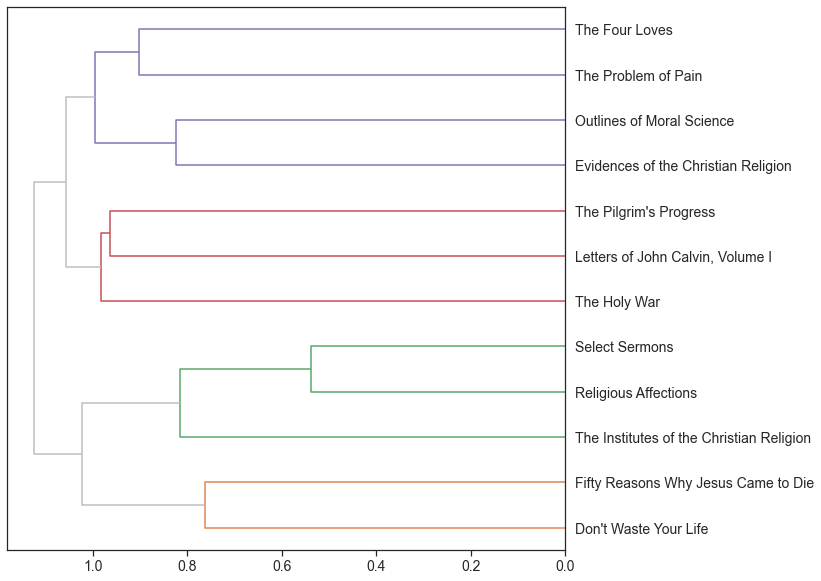

In [678]:
hca(PAIRS.cosine, color_thresh=1)

<Figure size 432x288 with 0 Axes>

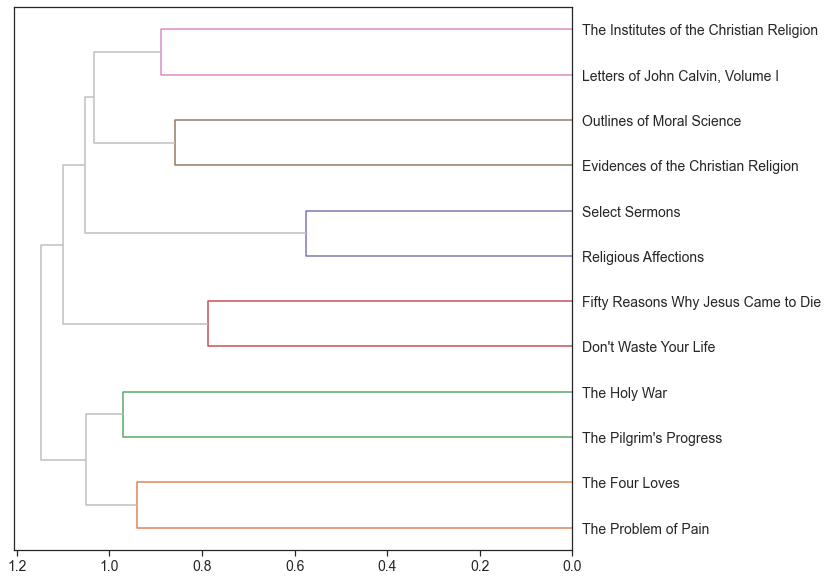

In [680]:
hca(PAIRS.correlation, color_thresh=1)

# Principal Component Analysis (PCA)

In [681]:
#Perform inner join on TOKEN and LIB to add author, year to TOKEN table:
OHCO_BOW = ['author', 'book', 'year', 'chap_num', 'para_num', 'sent_num', 'token_num']
TOKEN = pd.merge(TOKEN.reset_index(), LIB, on='book_id').set_index(OHCO_BOW)

In [682]:
TOKEN.head()

book_id  \
author book           year chap_num para_num sent_num token_num            
Lewis  The Four Loves 1960 1        1        0        0               10   
                                    2        0        1               10   
                                                      2               10   
                                                      3               10   
                                                      6               10   

                                                                 book_num  \
author book           year chap_num para_num sent_num token_num             
Lewis  The Four Loves 1960 1        1        0        0                 1   
                                    2        0        1                 1   
                                                      2                 1   
                                                      3                 1   
                                                      6                 1   

                                                                              pos_tuple  \
author book           year chap_num para_num sent_num token_num                           
Lewis  The Four Loves 1960 1        1        0        0          ('Introduction', 'NN')   
                                    2        0        1                  ('God', 'NNP')   
                                                      2                   ('is', 'VBZ')   
                                                      3                 ('love', 'RBR')   
                                                      6                 ('says', 'VBZ')   

                                                                 pos  \
author book           year chap_num para_num sent_num token_num        
Lewis  The Four Loves 1960 1        1        0        0           NN   
                                    2        0        1          NNP   
                                                      2          VBZ   
                                                      3          RBR   
                                                      6          VBZ   

                                                                    token_str  \
author book           year chap_num para_num sent_num token_num                 
Lewis  The Four Loves 1960 1        1        0        0          Introduction   
                                    2        0        1                   God   
                                                      2                    is   
                                                      3                  love   
                                                      6                  says   

                                                                     term_str  \
author book           year chap_num para_num sent_num token_num                 
Lewis  The Four Loves 1960 1        1        0        0          introduction   
                                    2        0        1                   god   
                                                      2                    is   
                                                      3                  love   
                                                      6                  says   

                                                                 term_id  \
author book           year chap_num para_num sent_num token_num            
Lewis  The Four Loves 1960 1        1        0        0          15236.0   
                                    2        0        1          12782.0   
                                                      2              NaN   
                                                      3          16648.0   
                                                      6          23510.0   

                                                                                               book_file  
author book           year chap_num para_num sent_num token_num          

### Turn TOKEN into Bag-of-Words (BOW):

In [683]:
#Create Bag-of-Words:
bag = ['book']
BOW = TOKEN.groupby(bag+['term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})
BOW['c'] = BOW.n.astype('bool').astype('int')
BOW.head()

n  c
book                  term_id      
Don't Waste Your Life 2000.0   1  1
                      2001.0   1  1
                      2003.0   1  1
                      2004.0   2  1
                      2005.0   1  1

### Turn BOW into Document-Term Matrix (DTCM)

In [684]:
#Create Document Term-Count Matrix:
count_method = 'n'
DTCM = BOW[count_method].unstack().fillna(0).astype('int')
DTCM.head()

term_id,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,...,29438.0,29439.0,29440.0,29441.0,29442.0,29443.0,29444.0,29445.0,29446.0,29447.0
book,,,,,,,,,,,,,,,,,,,,,
Don't Waste Your Life,1,1,0,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Evidences of the Christian Religion,0,0,0,0,4,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fifty Reasons Why Jesus Came to Die,0,0,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"Letters of John Calvin, Volume I",0,1,0,0,2,6,2,0,0,1,...,0,0,1,0,0,0,11,1,1,1
Outlines of Moral Science,0,0,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature Reduction (using top 2000 terms)

In [697]:
#tfidf_sum() from the VOCAB table to do this. Select the top 4000 terms and use them to select the columns of the TFIDF table.
reduced = list(VOCAB.sort_values(by=['tfidf_sum'], ascending=False)[0:2000].index)
DTCM_reduced = DTCM[reduced]
TFIDF_reduced = TFIDF_chap[reduced]
#DTCM_reduced.head()
TFIDF_reduced.head()

term_id                    19849.0  20378.0  5965.0    12782.0  17851.0  \
book_id book_num chap_num                                                 
1       1        1             0.0      0.0      0.0  0.000000      0.0   
                 2             0.0      0.0      0.0  0.000273      0.0   
                 3             0.0      0.0      0.0  0.000000      0.0   
                 4             0.0      0.0      0.0  0.000000      0.0   
                 5             0.0      0.0      0.0  0.000000      0.0   

term_id                    15547.0   6004.0    16257.0  2960.0   13567.0  ...  \
book_id book_num chap_num                                                 ...   
1       1        1             0.0  0.000000  0.003924      0.0      0.0  ...   
                 2             0.0  0.000723  0.001106      0.0      0.0  ...   
                 3             0.0  0.000000  0.000000      0.0      0.0  ...   
                 4             0.0  0.000000  0.009985      0.0      0.0  ...   
                 5             0.0  0.000000  0.000000      0.0      0.0  ...   

term_id                    19488.0  22480.0  28464.0  25626.0  13852.0  \
book_id book_num chap_num                                                
1       1        1             0.0      0.0      0.0      0.0      0.0   
                 2             0.0      0.0      0.0      0.0      0.0   
                 3             0.0      0.0      0.0      0.0      0.0   
                 4             0.0      0.0      0.0      0.0      0.0   
                 5             0.0      0.0      0.0      0.0      0.0   

term_id                    7254.0   6706.0   25149.0  2572.0   3296.0   
book_id book_num chap_num                                               
1       1        1             0.0      0.0      0.0      0.0      0.0  
                 2             0.0      0.0      0.0      0.0      0.0  
                 3             0.0      0.0      0.0      0.0      0.0  
                 4             0.0      0.0      0.0      0.0      0.0  
                 5             0.0      0.0      0.0      0.0      0.0  

[5 rows x 2000 columns]

### Extract Term Covariance Matrix (COV) from Reduced TFIDF

In [698]:
COV = TFIDF_reduced.cov() #Built-in Pandas method for coviariance
#COV = DTCM_reduced.T.dot(DTCM_reduced) / (DTCM_reduced.shape[0] - 1) #By-hand calculation
COV.head()

term_id,19849.0,20378.0,5965.0,12782.0,17851.0,15547.0,6004.0,16257.0,2960.0,13567.0,...,19488.0,22480.0,28464.0,25626.0,13852.0,7254.0,6706.0,25149.0,2572.0,3296.0
term_id,,,,,,,,,,,,,,,,,,,,,
19849.0,0.001473,0.001098,-0.000003,-0.000003,-0.000003,-0.000002,-1.721874e-06,-1.596576e-06,-0.000002,-1.469136e-06,...,-1.948764e-07,-1.994093e-07,-1.967933e-07,-1.973272e-07,-1.991844e-07,-1.975256e-07,-1.987550e-07,-1.958369e-07,-1.977208e-07,-1.199140e-07
20378.0,0.001098,0.000829,-0.000003,-0.000002,-0.000002,-0.000002,-1.385064e-06,-1.269613e-06,-0.000001,-1.239423e-06,...,-9.702603e-08,-1.686298e-07,-1.652335e-07,-1.608176e-07,-1.694951e-07,-1.682103e-07,-1.447953e-07,-1.617315e-07,-1.689675e-07,-1.648396e-07
5965.0,-0.000003,-0.000003,0.000007,0.000002,-0.000002,0.000003,-3.509666e-07,-9.029412e-07,-0.000001,-1.155679e-06,...,-5.655600e-08,1.932829e-07,8.808079e-08,-3.419032e-08,-1.482181e-07,-1.244672e-07,-1.179096e-07,1.849081e-07,-5.988645e-08,-6.034246e-08
12782.0,-0.000003,-0.000002,0.000002,0.000003,-0.000001,0.000001,-4.732357e-07,-8.700239e-07,-0.000001,-1.069506e-06,...,-8.502266e-08,1.351917e-07,4.078062e-08,-8.180676e-08,-1.426043e-07,-5.422261e-09,-1.027203e-07,-2.867046e-08,4.006208e-08,-1.733517e-09
17851.0,-0.000003,-0.000002,-0.000002,-0.000001,0.000024,-0.000001,-1.117704e-06,-1.045444e-06,-0.000001,-9.559835e-07,...,-1.267103e-07,1.607996e-08,-8.424576e-08,-1.250752e-07,-1.249293e-07,1.906537e-07,-1.255831e-07,4.250496e-08,-1.215206e-07,-1.239146e-09


### Decompose COV Matrix & Convert Eigen Data to Dataframes

In [699]:
eig_vals, eig_vecs = eigh(COV)

In [700]:
TERM_IDX = COV.index
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'term_id'
EIG_VAL.head()
#EIG_VEC.iloc[:5, :10].style.background_gradient()

,eig_val
term_id,
19849.0,-1.758042e-18
20378.0,-5.470322e-19
5965.0,-1.730767e-19
12782.0,-1.729371e-19
17851.0,-1.272143e-19


### Combine Eigenvalues & Eigenvectors

In [701]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
EIG_PAIRS.head()

,eig_val,19849.0,20378.0,5965.0,12782.0,17851.0,15547.0,6004.0,16257.0,2960.0,...,19488.0,22480.0,28464.0,25626.0,13852.0,7254.0,6706.0,25149.0,2572.0,3296.0
term_id,,,,,,,,,,,,,,,,,,,,,
19849.0,-1.758042e-18,-0.001729,0.002233,0.003309,-0.030701,0.005297,-0.017340,-0.012670,-0.008137,-0.680919,...,-0.004942,-0.002856,-0.000444,0.003135,-0.002537,-0.004811,0.001054,-0.005555,0.004061,0.003388
20378.0,-5.470322e-19,0.002599,-0.003702,-0.018686,-0.009005,0.010424,-0.001325,-0.003836,-0.014521,0.007826,...,-0.018595,0.000367,0.006797,-0.032439,0.005443,-0.001344,0.001004,0.004337,0.016549,-0.006336
5965.0,-1.730767e-19,0.004117,-0.003000,-0.077241,0.136069,0.063207,0.117105,0.010569,0.084367,-0.036072,...,-0.012157,-0.000741,-0.001198,0.012432,0.002050,-0.004502,0.011297,0.010736,0.000605,-0.011591
12782.0,-1.729371e-19,0.000000,0.001665,-0.037743,-0.019155,0.010698,0.071971,0.011172,0.018032,0.044752,...,-0.005638,0.007623,0.013609,0.004142,0.045064,0.001350,-0.010204,-0.006734,-0.016938,0.000984
17851.0,-1.272143e-19,0.000000,0.001939,0.065268,-0.096979,-0.061351,0.031244,-0.000733,-0.018007,0.021125,...,0.008803,0.004080,-0.009806,0.007000,0.011790,-0.003393,0.001825,0.011366,0.009529,0.000017


### Extract Top K (10) Components based on Explained Variance

In [702]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS

,eig_val,19849.0,20378.0,5965.0,12782.0,17851.0,15547.0,6004.0,16257.0,2960.0,...,22480.0,28464.0,25626.0,13852.0,7254.0,6706.0,25149.0,2572.0,3296.0,exp_var
PC0,0.002296,0.800305,0.599369,-0.001819,-0.001678,-0.001512,-0.001035,-0.000962,-0.000890,-0.001170,...,-0.000115,-0.000112,-0.000111,-0.000116,-0.000113,-0.000106,-0.000111,-0.000113,-0.000084,44.88
PC1,0.000519,-0.001815,-0.000478,0.004015,0.003564,0.002544,0.002376,0.001815,0.001666,-0.673606,...,0.000260,0.000233,0.000222,0.000266,0.000229,0.000229,0.000242,0.000215,0.000214,10.15
PC2,0.000275,-0.026650,0.031375,-0.009605,-0.008121,-0.009214,-0.005897,-0.001737,0.000117,0.004534,...,-0.000658,-0.000566,-0.000164,-0.000621,-0.000592,0.000174,-0.000535,-0.000417,-0.000223,5.38
PC3,0.000216,-0.109477,0.126485,-0.005188,-0.004635,-0.004540,-0.003461,-0.000488,-0.000509,0.001997,...,-0.000395,-0.000320,-0.000106,-0.000244,-0.000343,0.000533,-0.000245,-0.000194,-0.000093,4.22
PC4,0.000068,-0.000615,0.001401,0.036812,0.028579,0.388586,0.024047,-0.031728,-0.080340,-0.002177,...,0.004213,0.001657,-0.004331,-0.030471,0.008634,-0.004562,0.001585,-0.002310,-0.000283,1.34
PC5,0.000066,0.000324,-0.000105,-0.187329,-0.092794,0.371085,-0.132757,0.001793,0.041530,-0.006824,...,-0.007730,-0.002879,0.000583,0.006456,0.006964,0.001359,-0.004465,-0.001274,0.001013,1.29
PC6,0.000059,-0.000691,0.001652,0.110686,0.055081,0.026199,0.079954,-0.024102,-0.019015,0.003443,...,0.005796,0.001786,-0.001461,-0.158261,0.000875,-0.003571,0.003144,-0.001836,-0.000712,1.16
PC7,0.000054,0.001179,-0.004511,-0.165591,-0.070926,-0.122854,-0.123845,0.056440,0.049555,-0.007611,...,-0.008406,-0.000684,0.005119,-0.124786,-0.001497,0.008437,-0.004293,0.004154,0.003385,1.05
PC8,0.000044,0.000558,-0.000783,0.011642,-0.001508,-0.131959,0.011281,0.008405,0.012458,0.005581,...,-0.001020,-0.000719,0.000979,-0.005780,-0.006532,0.001071,-0.000114,0.000730,-0.000436,0.86
PC9,0.000034,-0.000709,-0.000650,-0.018581,0.016391,-0.056853,0.012363,0.023825,-0.039430,0.001827,...,0.008804,0.005977,-0.001644,0.011969,0.000325,-0.000929,0.002055,-0.000427,0.001437,0.67


### Project DTCM onto Reduced Component Subspace, Creating Document-Component Table (DCM)

In [703]:
#Columns in 1st matrix * rows in the 2nd:
DCM = DTCM_reduced.dot(COMPS[TERM_IDX].T)
DCM

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
book,,,,,,,,,,
Don't Waste Your Life,-6.485271,10.296259,-27.547561,-14.430219,79.446661,-340.393653,188.128656,-278.527445,8.384177,7.739338
Evidences of the Christian Religion,-1.076136,6.072719,-22.539921,-8.627916,109.653407,-24.597609,66.107514,-94.399209,-31.920488,48.618302
Fifty Reasons Why Jesus Came to Die,-5.151065,8.176082,-21.369945,-9.966918,82.708478,-327.769750,191.021777,-300.343905,12.466656,-17.655493
"Letters of John Calvin, Volume I",-4.459785,-5.085849,84.004968,23.995229,-367.654967,100.539055,-217.166472,306.425183,53.525912,-220.102493
Outlines of Moral Science,-5.324506,1.099649,-20.697964,-7.114877,405.394679,342.220701,32.951683,-133.233038,-119.335836,-27.460814
Religious Affections,-14.695993,11.617884,-74.186510,-26.650166,360.882835,-332.293254,277.087453,-409.304829,-81.063328,186.678091
Select Sermons,-23.481249,20.518880,-95.544842,-51.632854,266.770775,-680.662656,385.399802,-559.353932,-26.443919,174.577411
The Four Loves,-3.777878,4.258299,-14.563135,-6.790496,46.270058,-47.595535,31.553826,-54.488288,-15.684985,17.995549
The Holy War,-9.131629,8.152108,-22.540889,-16.711027,-60.635047,-72.039458,-102.122503,68.652030,12.336787,115.469631


### Visualize PCA Results:
Add metadata (author & year) to DCM for visualization purposes

In [704]:
DCM = DCM.join(LIB.set_index('book'))
DCM['doc'] = DCM.apply(lambda x: "{}-{}".format(x.author, x.year), 1)
DCM.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,author,year,book_file,doc
book,,,,,,,,,,,,,,
Don't Waste Your Life,-6.485271,10.296259,-27.547561,-14.430219,79.446661,-340.393653,188.128656,-278.527445,8.384177,7.739338,Piper,2003,corpus\11_Piper_2003_Don't-Waste-Your-Life.txt,Piper-2003
Evidences of the Christian Religion,-1.076136,6.072719,-22.539921,-8.627916,109.653407,-24.597609,66.107514,-94.399209,-31.920488,48.618302,Alexander,1832,corpus\7_Alexander_1832_Evidences-of-the-Chris...,Alexander-1832
Fifty Reasons Why Jesus Came to Die,-5.151065,8.176082,-21.369945,-9.966918,82.708478,-327.769750,191.021777,-300.343905,12.466656,-17.655493,Piper,2004,corpus\12_Piper_2004_Fifty-Reasons-Why-Jesus-C...,Piper-2004
"Letters of John Calvin, Volume I",-4.459785,-5.085849,84.004968,23.995229,-367.654967,100.539055,-217.166472,306.425183,53.525912,-220.102493,Calvin,1536,"corpus\1_Calvin_1536_Letters-of-John-Calvin,-V...",Calvin-1536
Outlines of Moral Science,-5.324506,1.099649,-20.697964,-7.114877,405.394679,342.220701,32.951683,-133.233038,-119.335836,-27.460814,Alexander,1854,corpus\8_Alexander_1854_Outlines-of-Moral-Scie...,Alexander-1854


In [708]:
DCM[0:10]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,author,year,book_file,doc
book,,,,,,,,,,,,,,
Don't Waste Your Life,-6.485271,10.296259,-27.547561,-14.430219,79.446661,-340.393653,188.128656,-278.527445,8.384177,7.739338,Piper,2003,corpus\11_Piper_2003_Don't-Waste-Your-Life.txt,Piper-2003
Evidences of the Christian Religion,-1.076136,6.072719,-22.539921,-8.627916,109.653407,-24.597609,66.107514,-94.399209,-31.920488,48.618302,Alexander,1832,corpus\7_Alexander_1832_Evidences-of-the-Chris...,Alexander-1832
Fifty Reasons Why Jesus Came to Die,-5.151065,8.176082,-21.369945,-9.966918,82.708478,-327.769750,191.021777,-300.343905,12.466656,-17.655493,Piper,2004,corpus\12_Piper_2004_Fifty-Reasons-Why-Jesus-C...,Piper-2004
"Letters of John Calvin, Volume I",-4.459785,-5.085849,84.004968,23.995229,-367.654967,100.539055,-217.166472,306.425183,53.525912,-220.102493,Calvin,1536,"corpus\1_Calvin_1536_Letters-of-John-Calvin,-V...",Calvin-1536
Outlines of Moral Science,-5.324506,1.099649,-20.697964,-7.114877,405.394679,342.220701,32.951683,-133.233038,-119.335836,-27.460814,Alexander,1854,corpus\8_Alexander_1854_Outlines-of-Moral-Scie...,Alexander-1854
Religious Affections,-14.695993,11.617884,-74.186510,-26.650166,360.882835,-332.293254,277.087453,-409.304829,-81.063328,186.678091,Edwards,1746,corpus\5_Edwards_1746_Religious-Affections.txt,Edwards-1746
Select Sermons,-23.481249,20.518880,-95.544842,-51.632854,266.770775,-680.662656,385.399802,-559.353932,-26.443919,174.577411,Edwards,1750,corpus\6_Edwards_1750_Select-Sermons.txt,Edwards-1750
The Four Loves,-3.777878,4.258299,-14.563135,-6.790496,46.270058,-47.595535,31.553826,-54.488288,-15.684985,17.995549,Lewis,1960,corpus\10_Lewis_1960_The-Four-Loves.txt,Lewis-1960
The Holy War,-9.131629,8.152108,-22.540889,-16.711027,-60.635047,-72.039458,-102.122503,68.652030,12.336787,115.469631,Bunyan,1682,corpus\4_Bunyan_1682_The-Holy-War.txt,Bunyan-1682


### Scree Plot:
Here we see that there is a steep drop-off in explained variance between the first two components, and then another decently sized drop-off between components 3 and 4. As such, we will primarily focus our visualizations and analysis on our first two PC's. 

Text(0, 0.5, 'Variance Explained')

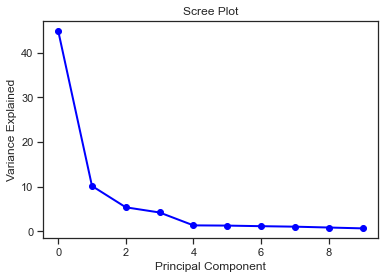

In [705]:
pc_num = COMPS.reset_index().index
plt.plot(pc_num, COMPS.exp_var, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

### First Two Principal Components:
By Author:

[Text(0.5, 1.0, "PC's 0 & 1, by Author")]

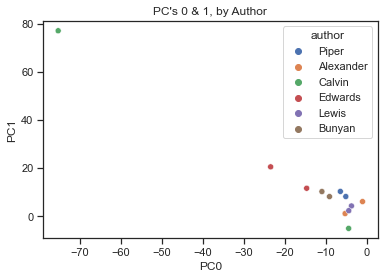

In [721]:
sns.scatterplot(x='PC0', y='PC1', data=DCM, hue='author').set(title='PC\'s 0 & 1, by Author')

[Text(0.5, 1.0, "PC's 0 & 1, by Author\n (excluding Calvin's 2nd book)")]

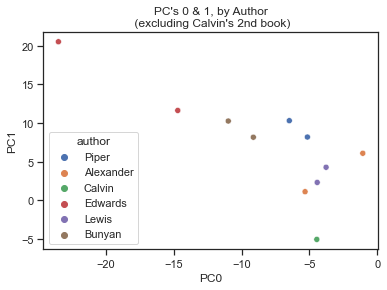

In [720]:
# Plot reproduced, excluding Calvin's 2nd work which was far and away from any others. This will help us better visualize the groupings of the other books:
sns.scatterplot(x='PC0', y='PC1', data=DCM[DCM.doc != 'Calvin-1541'], hue='author').set(title='PC\'s 0 & 1, by Author\n (excluding Calvin\'s 2nd book)')

By Year:

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

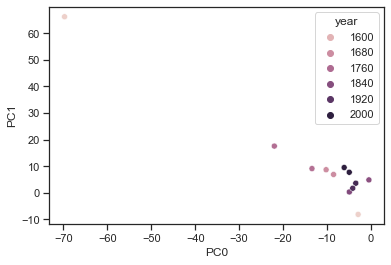

In [696]:
sns.scatterplot(x='PC0', y='PC1', data=DCM, hue='year')

### 2nd & 3rd Components:

[Text(0.5, 1.0, "PC's 1 & 2, by Author\n (excluding Calvin's 2nd book)")]

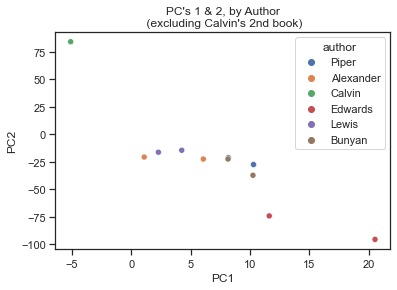

In [722]:
sns.scatterplot(x='PC1', y='PC2', data=DCM[DCM.doc != 'Calvin-1541'], hue='author').set(title='PC\'s 1 & 2, by Author\n (excluding Calvin\'s 2nd book)')

### Look at PCA Loadings:

In [715]:
LOADINGS = COMPS[TERM_IDX].T
LOADINGS.index.name = 'term_id'
LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [716]:
LOADINGS.head().style.background_gradient()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,term_str
term_id,,,,,,,,,,,
19849.0,0.800305,-0.001815,-0.026650,-0.109477,-0.000615,0.000324,-0.000691,0.001179,0.000558,-0.000709,persecutions
20378.0,0.599369,-0.000478,0.031375,0.126485,0.001401,-0.000105,0.001652,-0.004511,-0.000783,-0.000650,policy
5965.0,-0.001819,0.004015,-0.009605,-0.005188,0.036812,-0.187329,0.110686,-0.165591,0.011642,-0.018581,christ
12782.0,-0.001678,0.003564,-0.008121,-0.004635,0.028579,-0.092794,0.055081,-0.070926,-0.001508,0.016391,god
17851.0,-0.001512,0.002544,-0.009214,-0.004540,0.388586,0.371085,0.026199,-0.122854,-0.131959,-0.056853,moral


In [727]:
l0_pos = LOADINGS.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
l0_neg = LOADINGS.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
l1_pos = LOADINGS.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
l1_neg = LOADINGS.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')
l2_pos = LOADINGS.sort_values('PC2', ascending=True).head(10).term_str.str.cat(sep=' ')
l2_neg = LOADINGS.sort_values('PC2', ascending=False).head(10).term_str.str.cat(sep=' ')

In [728]:
print('Books PC0+', l0_pos)
print('Books PC0-', l0_neg)
print('Books PC1+', l1_pos)
print('Books PC1-', l1_neg)
print('Books PC2+', l2_pos)
print('Books PC2-', l2_neg)

Books PC0+ christ god moral anabaptist hermann jesus church letter bible law
Books PC0- persecutions policy frankfort protestants conferences catholic opening roman property assembly
Books PC1+ anabaptist hermann v discussion understanding mention good persecutions policy intellectual
Books PC1- christ god frankfort alexandre moral jesus germany lecture princes negotiations
Books PC2+ persecutions christ moral god jesus bible sin romans law faculty
Books PC2- alexandre negotiations lecture henry details protestant germany reconciliation princes bucer


## Save DCM & LOADINGS tables to csv:

In [729]:
DCM.to_csv('DCM.csv')
LOADINGS.to_csv('LOADINGS.csv')

# Linear Discriminant Analysis (LDA)

### Setup:

In [730]:
n_terms = 4000
n_topics = 20
max_iter = 5
OHCO = ['book_id', 'chap_num', 'para_num']

### Convert TOKEN to table of paragraphs:
Here we are creating an F1 style corpus from our annotated TOKEN table, keeping only regular nouns. This is to use w/ Scikit Learn

In [731]:
# Load in TOKEN table
TOKEN = pd.read_csv('TOKEN.csv')

In [732]:
TOKEN.term_str = TOKEN.term_str.astype(str)

PARAS = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

In [733]:
BOOKS = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO[:1]).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'book_str'})

In [734]:
PARAS.head()

para_str
book_id chap_num para_num                                                   
1       1        0         letter series correspondence belles law afterw...
                 1                         calvin friendships illness father
                 3         motives peculiar circumstances punctuality que...
                 4         father man morals understanding judgment testi...
                 5         year letters allusion event influence life stu...

In [735]:
BOOKS.head()

,book_str
book_id,
1,letter series correspondence belles law afterw...
2,nature sections sum wisdom viz knowledge ourse...
3,wilderness world place den place dream behold ...
4,travels regions countries chance continent cou...
5,part love rejoice joy glory words state minds ...


### Create Vector Space
Here we use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [736]:
# Paragraphs:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names_out()

# Books:
tfv2 = CountVectorizer(max_features=n_terms, stop_words='english')
tf2 = tfv.fit_transform(BOOKS.book_str)
TERMS2 = tfv.get_feature_names_out()

### Generate Model

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [737]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
lda2 = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

### THETA

In [744]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
THETA.columns.name = 'topic_id'

THETA2 = pd.DataFrame(lda2.fit_transform(tf2), index=BOOKS.index)
THETA2.columns.name = 'topic_id'

In [745]:
THETA.sample(5).style.background_gradient()

In [746]:
THETA2.sample(5).style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
book_id,,,,,,,,,,,,,,,,,,,,
5,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.999967,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
11,0.000006,0.000006,0.000006,0.001981,0.000006,0.000006,0.013805,0.021874,0.000006,0.000006,0.002198,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.960053,0.000006
1,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.999959,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
4,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.999933,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
8,0.000006,0.000006,0.999888,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006


### PHI

In [747]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

PHI2 = pd.DataFrame(lda2.components_, columns=TERMS)
PHI2.index.name = 'topic_id'
PHI2.columns.name  = 'term_str'

In [748]:
PHI.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
term_str,,,,,,,,,,,,,,,,,,,,
abasement,0.180324,0.050000,2.271888,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.135687,0.050000,11.612102,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
abettors,0.050000,0.050000,3.050000,0.050000,0.050000,0.050000,0.050000,0.050000,3.050000,0.050000,2.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
abhorrence,7.110838,0.050000,3.836910,0.050000,0.050000,0.050000,0.050713,0.050000,0.050000,0.050000,2.742428,0.484780,0.050000,0.067551,0.050000,0.050000,0.050000,0.050000,2.056780,0.050000
abilities,0.050000,0.050000,2.864961,2.168411,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.764026,0.050000,0.050000,2.490348,0.050000,0.050000,0.962254,0.050000,0.050000,0.050000
ability,0.050000,0.600378,3.426757,0.050001,0.159234,0.108146,11.415502,11.991064,14.156463,5.037559,7.630648,0.050000,0.365397,0.198564,1.300004,4.330247,0.050000,0.050000,2.267597,3.762441


In [749]:
PHI2.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
term_str,,,,,,,,,,,,,,,,,,,,
abasement,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,11.105889,0.050000,0.050000,0.050000,1.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,1.994111
abettors,0.050000,0.050000,3.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,2.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,3.050000
abhorrence,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,8.076524,0.050000,0.050000,0.050000,2.050000,2.058628,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,4.014847
abilities,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,6.076994,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,3.023006
ability,0.050000,0.050000,3.537786,2.581327,0.050000,0.050000,14.727377,1.078280,0.050000,0.050000,9.575428,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,5.489324,29.360478


### Return Top Terms per Topic

In [ ]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

TOPICS2 = PHI2.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [751]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,9
topic_id,,,,,,,,,,
0,fear,hill,way,time,cup,love,people,sufferings,life,ends
1,things,joy,world,way,cross,life,man,glory,house,day
2,love,man,things,men,nature,mind,conscience,sense,affections,thing
3,sin,works,righteousness,law,repentance,sins,punishment,man,faith,sinner
4,end,things,business,knowledge,prayer,men,way,women,man,library
5,men,thee,reason,act,man,acts,actions,mind,thou,way
6,affections,things,religion,persons,nature,evidence,men,power,time,mind
7,man,work,grace,life,mind,men,nature,creatures,spirit,heart
8,man,body,glory,things,nature,life,flesh,grace,bread,faith


In [752]:
TOPICS2

term_str,0,1,2,3,4,5,6,7,8,9
topic_id,,,,,,,,,,
0,abasement,precedence,pp,practice,practices,praise,praises,pray,prayer,prayers
1,abasement,precedence,pp,practice,practices,praise,praises,pray,prayer,prayers
2,man,men,nature,mind,power,reason,actions,truth,act,world
3,death,sin,blood,sins,law,people,cross,world,suffering,power
4,abasement,precedence,pp,practice,practices,praise,praises,pray,prayer,prayers
5,abasement,precedence,pp,practice,practices,praise,praises,pray,prayer,prayers
6,things,men,man,nature,love,heart,time,affections,glory,religion
7,man,way,heart,things,men,place,pilgrims,thou,time,thee
8,abasement,precedence,pp,practice,practices,praise,praises,pray,prayer,prayers


## Save TOPIC tables:

In [753]:
TOPICS.to_csv('TOPIC_TERM.csv')
#TOPICS2.to_csv('TOPIC_TERM_book.csv')
THETA.to_csv('TOPIC_DOC.csv')
#THETA2.to_csv('TOPIC_DOC_book.csv')

In [754]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x[:7].astype('str')), 1)
TOPICS2['label'] = TOPICS2.apply(lambda x: str(x.name) + ' ' + ' '.join(x[:7].astype('str')), 1)

In [755]:
TOPICS.label

topic_id
0                  0 fear hill way time cup love people
1                 1 things joy world way cross life man
2          2 love man things men nature mind conscience
3     3 sin works righteousness law repentance sins ...
4        4 end things business knowledge prayer men way
5                5 men thee reason act man acts actions
6     6 affections things religion persons nature ev...
7                 7 man work grace life mind men nature
8             8 man body glory things nature life flesh
9     9 men things truth religion reason revelation ...
10    10 time letter way brother brethren account ma...
11              11 town thou thee men captains gate man
12       12 sec chapter law sacraments doctrine lib man
13    13 knowledge men things people earth glory saints
14      14 sins mercy righteousness blood man sin death
15                   15 way tom day time wrath hist man
16    16 objection liberty worship sections answer m...
17    17 church place power word office

In [756]:
TOPICS2.label

topic_id
0     0 abasement precedence pp practice practices p...
1     1 abasement precedence pp practice practices p...
2            2 man men nature mind power reason actions
3               3 death sin blood sins law people cross
4     4 abasement precedence pp practice practices p...
5     5 abasement precedence pp practice practices p...
6               6 things men man nature love heart time
7             7 man way heart things men place pilgrims
8     8 abasement precedence pp practice practices p...
9     9 abasement precedence pp practice practices p...
10    10 time letter way brethren brother account ma...
11             11 town men captains man thee time place
12    12 abasement precedence pp practice practices ...
13    13 abasement precedence pp practice practices ...
14    14 abasement precedence pp practice practices ...
15    15 abasement precedence pp practice practices ...
16    16 abasement precedence pp practice practices ...
17    17 abasement precedence pp practi

### Sort Topics by Doc Weight

In [757]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS2['doc_weight_sum'] = THETA2.sum()

<AxesSubplot:ylabel='label'>

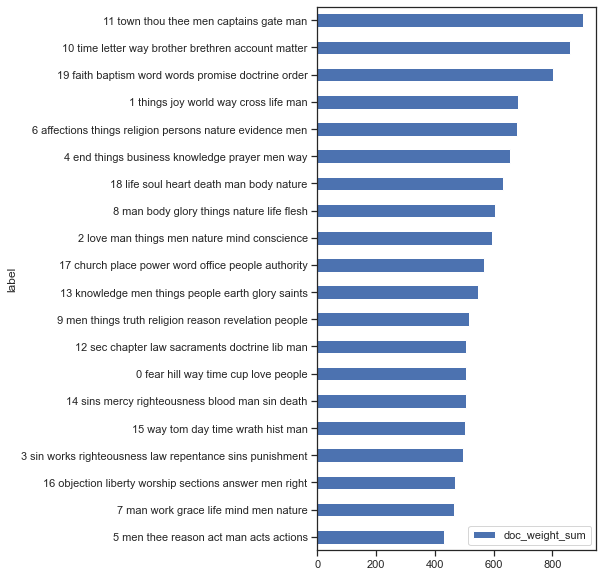

In [758]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

<AxesSubplot:ylabel='label'>

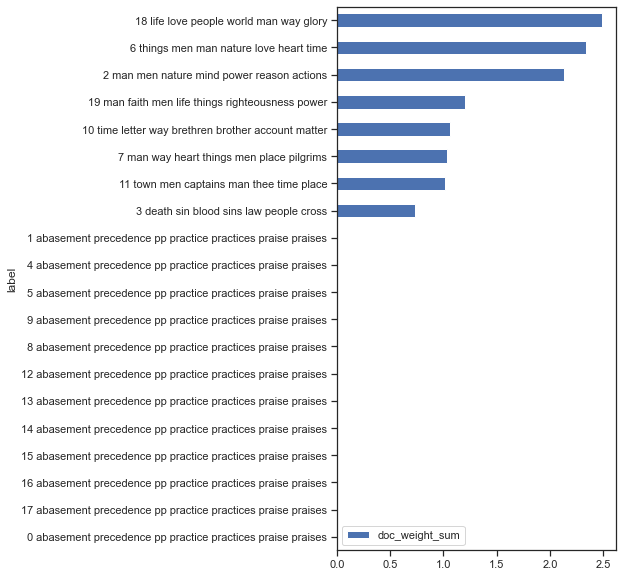

In [759]:
TOPICS2.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

### Explore Topics by Author

In [760]:
LIB = pd.read_csv('LIB.csv').set_index('book_id')

In [761]:
topic_cols = [t for t in range(n_topics)]

In [762]:
AUTHORS = THETA.join(LIB, on='book_id')\
    .reset_index().set_index(['author']+OHCO)\
    .groupby('author')[topic_cols].mean()\
    .T                                            
AUTHORS.index.name = 'topic_id'

AUTHORS2 = THETA2.join(LIB, on='book_id')\
    .reset_index().set_index(['author']+OHCO[:1])\
    .groupby('author')[topic_cols].mean()\
    .T                                            
AUTHORS2.index.name = 'topic_id'

In [763]:
AUTHORS['top_terms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)
AUTHORS2['top_terms'] = TOPICS2[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [764]:
AUTHORS.sort_values('Lewis', ascending=False)[0:5].style.background_gradient()

author,Alexander,Bunyan,Calvin,Edwards,Lewis,Piper,top_terms
topic_id,,,,,,,
2,0.100181,0.024416,0.022436,0.123048,0.188681,0.030782,love man things men nature mind conscience sense affections thing
18,0.032226,0.047275,0.028492,0.070302,0.156701,0.106627,life soul heart death man body nature happiness way love
1,0.017408,0.072345,0.018762,0.046912,0.098854,0.179631,things joy world way cross life man glory house day
5,0.118313,0.042044,0.021518,0.033477,0.057053,0.026536,men thee reason act man acts actions mind thou way
9,0.128867,0.031097,0.034709,0.053337,0.054509,0.037652,men things truth religion reason revelation people light knowledge word


In [765]:
AUTHORS2.sort_values('Lewis', ascending=False)[0:5].style.background_gradient()

author,Alexander,Bunyan,Calvin,Edwards,Lewis,Piper,top_terms
topic_id,,,,,,,
18,0.004997,0.000003,0.000001,0.000002,0.628373,0.611842,life love people world man way glory things work joy
2,0.702367,0.000003,0.000001,0.000002,0.359850,0.001120,man men nature mind power reason actions truth act world
7,0.000005,0.492312,0.000001,0.006123,0.009060,0.010943,man way heart things men place pilgrims thou time thee
19,0.099306,0.000003,0.498585,0.000104,0.002239,0.000009,man faith men life things righteousness power words word time
6,0.164788,0.000003,0.001413,0.992882,0.000355,0.006909,things men man nature love heart time affections glory religion


In [766]:
AUTHORS.sort_values('Calvin', ascending=False)[0:5].style.background_gradient()

author,Alexander,Bunyan,Calvin,Edwards,Lewis,Piper,top_terms
topic_id,,,,,,,
19,0.019744,0.018485,0.140695,0.017912,0.016297,0.032267,faith baptism word words promise doctrine order passage men salvation
10,0.036600,0.047351,0.128152,0.024038,0.039920,0.028082,time letter way brother brethren account matter friends day mind
8,0.032092,0.019681,0.079762,0.040470,0.046911,0.046629,man body glory things nature life flesh grace bread faith
17,0.022366,0.026881,0.079518,0.022203,0.018581,0.041959,church place power word office people authority churches bishops apostles
12,0.020640,0.020173,0.074595,0.016989,0.028536,0.033385,sec chapter law sacraments doctrine lib man cap words chap


In [767]:
AUTHORS2.sort_values('Calvin', ascending=False)[0:5].style.background_gradient()

author,Alexander,Bunyan,Calvin,Edwards,Lewis,Piper,top_terms
topic_id,,,,,,,
10,0.028467,0.000003,0.499980,0.000002,0.000008,0.001105,time letter way brethren brother account matter friends men order
19,0.099306,0.000003,0.498585,0.000104,0.002239,0.000009,man faith men life things righteousness power words word time
6,0.164788,0.000003,0.001413,0.992882,0.000355,0.006909,things men man nature love heart time affections glory religion
2,0.702367,0.000003,0.000001,0.000002,0.359850,0.001120,man men nature mind power reason actions truth act world
18,0.004997,0.000003,0.000001,0.000002,0.628373,0.611842,life love people world man way glory things work joy


In [937]:
px.scatter(AUTHORS.reset_index(), 'Calvin', 'Lewis', hover_name='top_terms')

In [939]:
px.scatter(AUTHORS.reset_index(), 'Lewis', 'Edwards', hover_name='top_terms')

In [949]:
px.scatter(AUTHORS.reset_index(), 'Lewis', 'Alexander', hover_name='top_terms')

In [940]:
px.scatter(AUTHORS.reset_index(), 'Edwards', 'Alexander', hover_name='top_terms')

In [768]:
px.scatter(AUTHORS.reset_index(), 'Lewis', 'Piper', hover_name='top_terms')
#px.scatter(AUTHORS.reset_index(), 'Lewis', 'Calvin', hover_name='topterms', text='topic_id').update_traces(mode='text')

### Explore Topics by Year:

In [770]:
topic_cols = [t for t in range(n_topics)]

YEARS = THETA.join(LIB, on='book_id')\
    .reset_index().set_index(['year']+OHCO)\
    .groupby('year')[topic_cols].mean()\
    .T                                            
YEARS.index.name = 'topic_id'

YEARS2 = THETA2.join(LIB, on='book_id')\
    .reset_index().set_index(['year']+OHCO[:1])\
    .groupby('year')[topic_cols].mean()\
    .T                                            
YEARS2.index.name = 'topic_id'

In [771]:
YEARS.T

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
year,,,,,,,,,,,,,,,,,,,,
1536,0.024299,0.019919,0.019717,0.016440,0.106778,0.022831,0.019767,0.023353,0.016731,0.030111,0.375346,0.031762,0.031766,0.019771,0.020729,0.091716,0.019052,0.066222,0.019946,0.023744
1541,0.035092,0.018330,0.023452,0.066034,0.016459,0.021028,0.019840,0.021891,0.103319,0.036427,0.035767,0.022946,0.090602,0.042146,0.045904,0.021965,0.078221,0.084488,0.031685,0.184404
1678,0.067035,0.089955,0.028219,0.031405,0.120665,0.052136,0.024201,0.059126,0.023902,0.034105,0.048004,0.114982,0.021426,0.040995,0.038788,0.077899,0.026067,0.024081,0.054937,0.022073
1682,0.037150,0.034805,0.016309,0.016481,0.035687,0.020529,0.013826,0.040700,0.010682,0.024684,0.045959,0.481239,0.017504,0.044022,0.024497,0.036483,0.024816,0.032850,0.030942,0.010836
1746,0.015848,0.030644,0.241845,0.025967,0.014701,0.026776,0.345019,0.025795,0.031996,0.028837,0.011196,0.010289,0.009688,0.060531,0.013352,0.009780,0.012115,0.011658,0.059514,0.014448
1750,0.046407,0.056842,0.050534,0.062193,0.085555,0.037567,0.079438,0.046271,0.045643,0.068293,0.031878,0.017533,0.021446,0.115252,0.058893,0.034992,0.015711,0.028641,0.076887,0.020026
1832,0.051064,0.023954,0.033561,0.044059,0.012842,0.058063,0.300064,0.027876,0.017318,0.148645,0.050776,0.018995,0.025458,0.038151,0.016161,0.017816,0.028883,0.030766,0.029394,0.026155
1854,0.004620,0.007022,0.205890,0.014367,0.010346,0.213913,0.123466,0.093570,0.055533,0.097486,0.014107,0.004840,0.012997,0.009827,0.007446,0.013021,0.056224,0.009038,0.036719,0.009570
1940,0.036212,0.089298,0.167666,0.029948,0.014210,0.076716,0.018105,0.065983,0.040624,0.057978,0.032178,0.012477,0.030702,0.023587,0.034993,0.018536,0.017284,0.018251,0.195999,0.019253


In [772]:
YEARS['top_terms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [774]:
YEARS.sort_values(1536, ascending=False)[0:5].style.background_gradient()

year,1536,1541,1678,1682,1746,1750,1832,1854,1940,1960,2003,2004,top_terms
topic_id,,,,,,,,,,,,,
10,0.375346,0.035767,0.048004,0.045959,0.011196,0.031878,0.050776,0.014107,0.032178,0.044477,0.030703,0.024641,time letter way brother brethren account matter friends day mind
4,0.106778,0.016459,0.120665,0.035687,0.014701,0.085555,0.012842,0.010346,0.014210,0.057138,0.036475,0.034868,end things business knowledge prayer men way women man library
15,0.091716,0.021965,0.077899,0.036483,0.009780,0.034992,0.017816,0.013021,0.018536,0.027819,0.044878,0.026375,way tom day time wrath hist man house home men
17,0.066222,0.084488,0.024081,0.032850,0.011658,0.028641,0.030766,0.009038,0.018251,0.018774,0.036791,0.048744,church place power word office people authority churches bishops apostles
12,0.031766,0.090602,0.021426,0.017504,0.009688,0.021446,0.025458,0.012997,0.030702,0.027261,0.035273,0.030907,sec chapter law sacraments doctrine lib man cap words chap


In [775]:
YEARS.sort_values(2004, ascending=False)[0:5].style.background_gradient()

year,1536,1541,1678,1682,1746,1750,1832,1854,1940,1960,2003,2004,top_terms
topic_id,,,,,,,,,,,,,
14,0.020729,0.045904,0.038788,0.024497,0.013352,0.058893,0.016161,0.007446,0.034993,0.032676,0.037384,0.168552,sins mercy righteousness blood man sin death forgiveness sacrifice salvation
18,0.019946,0.031685,0.054937,0.030942,0.059514,0.076887,0.029394,0.036719,0.195999,0.133568,0.100917,0.114124,life soul heart death man body nature happiness way love
1,0.019919,0.018330,0.089955,0.034805,0.030644,0.056842,0.023954,0.007022,0.089298,0.104480,0.230136,0.113320,things joy world way cross life man glory house day
3,0.016440,0.066034,0.031405,0.016481,0.025967,0.062193,0.044059,0.014367,0.029948,0.015245,0.021875,0.065499,sin works righteousness law repentance sins punishment man faith sinner
13,0.019771,0.042146,0.040995,0.044022,0.060531,0.115252,0.038151,0.009827,0.023587,0.011787,0.031850,0.057280,knowledge men things people earth glory saints children heaven kingdom


In [786]:
px.scatter(YEARS.reset_index(), 1536, 2004, hover_name='top_terms', title='Topics: 2004 vs 1536')
#px.scatter(YEARS.reset_index(), 1541, 2004, hover_name='topterms', text='topic_id').update_traces(mode='text')

In [794]:
px.scatter(YEARS.reset_index(), 1854, 1960, hover_name='top_terms', title='Topics: 1854 vs 1960')
#px.scatter(YEARS.reset_index(), 1541, 2004, hover_name='topterms', text='topic_id').update_traces(mode='text')

In [795]:
px.scatter(YEARS.reset_index(), 1854, 1940, hover_name='top_terms', title='Topics: 1854 vs 1940')

### Clutser Topics:

In [796]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [797]:
SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

In [798]:
labels = ["{}: {}".format(a,b) for a, b in zip(AUTHORS.index,  AUTHORS.top_terms.tolist())]

<Figure size 432x288 with 0 Axes>

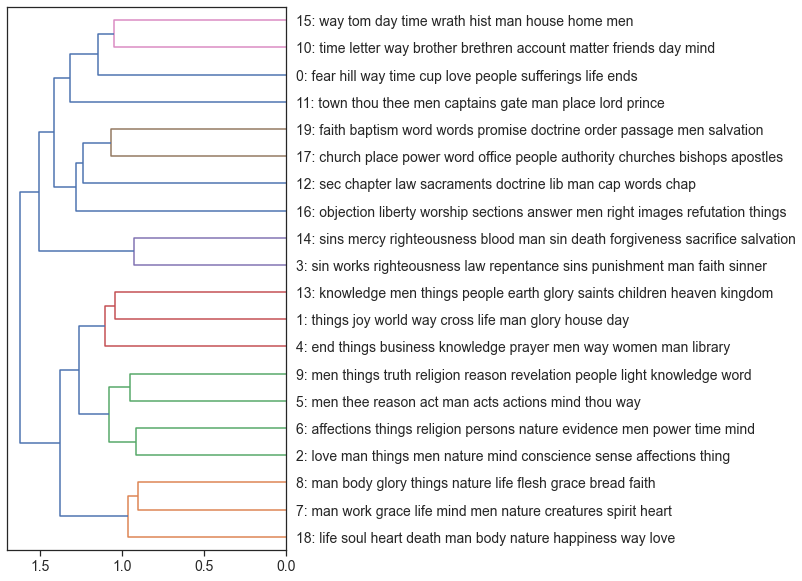

In [799]:
plot_tree(TREE, labels)

# Word2Vec

In [800]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num'] 
#BAG = OHCO[:3] # Paragraphs
BAG = OHCO[:4] # Sentences
window = 10

### Join TOKEN & LIB tables to be able to separate out by author:

In [801]:
# Re-import data tables
TOKEN = pd.read_csv('TOKEN.csv')
LIB = pd.read_csv('LIB.csv')

# Merge TOKEN & LIB tables on book_id column - make sure our TOKEN table doesn't already have author or year in it
TOKEN = TOKEN.merge(LIB.reset_index()[['book_id', 'author', 'year']], how='inner', on='book_id')
TOKEN = TOKEN.set_index(OHCO)

In [802]:
TOKEN.head()

book_num  \
book_id chap_num para_num sent_num token_num             
10      1        1        0        0                 1   
                 2        0        1                 1   
                                   2                 1   
                                   3                 1   
                                   6                 1   

                                                           pos_tuple  pos  \
book_id chap_num para_num sent_num token_num                                
10      1        1        0        0          ('Introduction', 'NN')   NN   
                 2        0        1                  ('God', 'NNP')  NNP   
                                   2                   ('is', 'VBZ')  VBZ   
                                   3                 ('love', 'RBR')  RBR   
                                   6                 ('says', 'VBZ')  VBZ   

                                                 token_str      term_str  \
book_id chap_num para_num sent_num token_num                               
10      1        1        0        0          Introduction  introduction   
                 2        0        1                   God           god   
                                   2                    is            is   
                                   3                  love          love   
                                   6                  says          says   

                                              term_id author  year  
book_id chap_num para_num sent_num token_num                        
10      1        1        0        0          15236.0  Lewis  1960  
                 2        0        1          12782.0  Lewis  1960  
                                   2              NaN  Lewis  1960  
                                   3          16648.0  Lewis  1960  
                                   6          23510.0  Lewis  1960

## Create separate tables for various authors:

In [803]:
TOKEN_stopless = TOKEN[TOKEN.term_id.notnull()] # To manually remove stopwords instead of relying on downampling in word2vec

# Create separate dataframe tables for each author (variables are named by author's last name in all caps, e.g. CALVIN)
for author in list(TOKEN.author.unique()):
    x = author.upper()
    exec(x + " = TOKEN_stopless.loc[TOKEN_stopless['author'] == author]")

In [804]:
BUNYAN.sample(5)

book_num             pos_tuple  \
book_id chap_num para_num sent_num token_num                                   
3       5        101      2        25                1      ('makes', 'VBZ')   
4       1        614      5        16                1  ('especially', 'RB')   
3       3        33       1        45                1        ('hill', 'NN')   
4       1        193      2        33                1       ('party', 'NN')   
                 307      0        61                1   ('provoked', 'VBN')   

                                              pos   token_str    term_str  \
book_id chap_num para_num sent_num token_num                                
3       5        101      2        25         VBZ       makes       makes   
4       1        614      5        16          RB  especially  especially   
3       3        33       1        45          NN        hill        hill   
4       1        193      2        33          NN       party       party   
                 307      0        61         VBN    provoked    provoked   

                                              term_id  author  year  
book_id chap_num para_num sent_num token_num                         
3       5        101      2        25         16889.0  Bunyan  1678  
4       1        614      5        16         10653.0  Bunyan  1682  
3       3        33       1        45         13649.0  Bunyan  1678  
4       1        193      2        33         19503.0  Bunyan  1682  
                 307      0        61         21328.0  Bunyan  1682

### Convert author tables into Gensim corpora:

In [807]:
corpus_calvin = CALVIN[~CALVIN.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

corpus_bunyan = BUNYAN[~BUNYAN.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

corpus_edwards = EDWARDS[~EDWARDS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

corpus_alexander = ALEXANDER[~ALEXANDER.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

corpus_lewis = LEWIS[~LEWIS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

corpus_piper = PIPER[~PIPER.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

### Generate word embeddings for the various authors with Gensim's library:

In [808]:
# Create function to explicitly tell word2vec to not trim out certain high-frequency words, e.g. 'god', since this is being used in our analysis.
def my_rule(word, count, min_count):
    if word=='god' or word=='christ' or word=='lord' or word=='sin' or word=='heaven':
        return gensim.utils.RULE_KEEP
    else:
        return gensim.utils.RULE_DEFAULT

In [840]:
model_calvin = word2vec.Word2Vec(corpus_calvin, vector_size=246, window=window, min_count=200, workers=4, trim_rule=my_rule)
model_bunyan = word2vec.Word2Vec(corpus_bunyan, vector_size=246, window=window, min_count=200, workers=4, trim_rule=my_rule)
model_edwards = word2vec.Word2Vec(corpus_edwards, vector_size=246, window=window, min_count=200, workers=4, trim_rule=my_rule)
model_alexander = word2vec.Word2Vec(corpus_alexander, vector_size=246, window=window, min_count=100, workers=4, trim_rule=my_rule)
model_lewis = word2vec.Word2Vec(corpus_lewis, vector_size=246, window=window, min_count=50, workers=4, trim_rule=my_rule)
model_piper = word2vec.Word2Vec(corpus_piper, vector_size=246, window=window, min_count=50, workers=4, trim_rule=my_rule)

### Visualize with tSNE
Generate coordinates to plot

In [841]:
coords_calvin = pd.DataFrame(index=range(len(model_calvin.wv.key_to_index)))
coords_calvin['label'] = [w for w in model_calvin.wv.key_to_index]
coords_calvin['vector'] = coords_calvin['label'].apply(lambda x: model_calvin.wv.get_vector(x))

coords_bunyan = pd.DataFrame(index=range(len(model_bunyan.wv.key_to_index)))
coords_bunyan['label'] = [w for w in model_bunyan.wv.key_to_index]
coords_bunyan['vector'] = coords_bunyan['label'].apply(lambda x: model_bunyan.wv.get_vector(x))

coords_edwards = pd.DataFrame(index=range(len(model_edwards.wv.key_to_index)))
coords_edwards['label'] = [w for w in model_edwards.wv.key_to_index]
coords_edwards['vector'] = coords_edwards['label'].apply(lambda x: model_edwards.wv.get_vector(x))

coords_alexander = pd.DataFrame(index=range(len(model_alexander.wv.key_to_index)))
coords_alexander['label'] = [w for w in model_alexander.wv.key_to_index]
coords_alexander['vector'] = coords_alexander['label'].apply(lambda x: model_alexander.wv.get_vector(x))

coords_lewis = pd.DataFrame(index=range(len(model_lewis.wv.key_to_index)))
coords_lewis['label'] = [w for w in model_lewis.wv.key_to_index]
coords_lewis['vector'] = coords_lewis['label'].apply(lambda x: model_lewis.wv.get_vector(x))

coords_piper = pd.DataFrame(index=range(len(model_piper.wv.key_to_index)))
coords_piper['label'] = [w for w in model_piper.wv.key_to_index]
coords_piper['vector'] = coords_piper['label'].apply(lambda x: model_piper.wv.get_vector(x))

In [842]:
coords_piper.head()

,label,vector
0,us,"[0.004810041, -0.018502813, -0.007124237, 0.00..."
1,life,"[0.0057003875, -0.019274073, -0.010753233, -0...."
2,one,"[0.00573253, -0.014377534, -0.005354204, -0.00..."
3,people,"[0.0009139009, -0.012796893, -0.0031562576, -0..."
4,death,"[0.0051200595, -0.018541986, -0.011239369, -0...."


### Use ScikitLearn's TSNE library

In [ ]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

tsne_values_calvin = tsne_model.fit_transform(coords_calvin['vector'].tolist())
tsne_values_bunyan = tsne_model.fit_transform(coords_bunyan['vector'].tolist())
tsne_values_edwards = tsne_model.fit_transform(coords_edwards['vector'].tolist())
tsne_values_alexander = tsne_model.fit_transform(coords_alexander['vector'].tolist())
tsne_values_lewis = tsne_model.fit_transform(coords_lewis['vector'].tolist())
tsne_values_piper = tsne_model.fit_transform(coords_piper['vector'].tolist())

In [844]:
coords_calvin['x'] = tsne_values_calvin[:,0]
coords_calvin['y'] = tsne_values_calvin[:,1]

coords_bunyan['x'] = tsne_values_bunyan[:,0]
coords_bunyan['y'] = tsne_values_bunyan[:,1]

coords_edwards['x'] = tsne_values_edwards[:,0]
coords_edwards['y'] = tsne_values_edwards[:,1]

coords_alexander['x'] = tsne_values_alexander[:,0]
coords_alexander['y'] = tsne_values_alexander[:,1]

coords_lewis['x'] = tsne_values_lewis[:,0]
coords_lewis['y'] = tsne_values_lewis[:,1]

coords_piper['x'] = tsne_values_piper[:,0]
coords_piper['y'] = tsne_values_piper[:,1]

In [845]:
coords_piper.head()

,label,vector,x,y
0,us,"[0.004810041, -0.018502813, -0.007124237, 0.00...",-4.510443,2.970210
1,life,"[0.0057003875, -0.019274073, -0.010753233, -0....",-4.515026,2.932331
2,one,"[0.00573253, -0.014377534, -0.005354204, -0.00...",-4.610857,0.393917
3,people,"[0.0009139009, -0.012796893, -0.0031562576, -0...",-4.375288,1.419346
4,death,"[0.0051200595, -0.018541986, -0.011239369, -0....",-4.544489,2.474358


In [878]:
test.sample(5)

,label,vector,x,y,term_str
term_id,,,,,
13421,heart,"[0.042512886, -0.079778604, -0.06634182, -0.05...",-14.249265,9.415865,heart
13211,hand,"[0.010160383, -0.03594173, -0.059096117, 0.017...",-10.591823,8.534792,hand
12684,given,"[-0.007245677, -0.020795822, -0.038057387, 0.0...",-2.944131,2.238579,given
13451,heaven,"[0.19671007, -0.049698774, -0.04774562, -0.026...",-16.419624,9.785700,heaven
27182,truly,"[-0.0024059021, -0.03053664, -0.030028151, 0.0...",-6.691158,6.922145,truly


## Save Word Embedding/Vector Tables to csv:
Add term_id, so they share indices with VOCAB table

In [879]:
coords_calvin = coords_calvin.merge(VOCAB.reset_index()[['term_id', 'term_str']], left_on='label', right_on='term_str').set_index('term_id')
coords_bunyan = coords_bunyan.merge(VOCAB.reset_index()[['term_id', 'term_str']], left_on='label', right_on='term_str').set_index('term_id')
coords_edwards = coords_edwards.merge(VOCAB.reset_index()[['term_id', 'term_str']], left_on='label', right_on='term_str').set_index('term_id')
coords_alexander = coords_alexander.merge(VOCAB.reset_index()[['term_id', 'term_str']], left_on='label', right_on='term_str').set_index('term_id')
coords_lewis = coords_lewis.merge(VOCAB.reset_index()[['term_id', 'term_str']], left_on='label', right_on='term_str').set_index('term_id')
coords_piper = coords_piper.merge(VOCAB.reset_index()[['term_id', 'term_str']], left_on='label', right_on='term_str').set_index('term_id')

coords_calvin.to_csv('EMBEDDINGS_CALVIN.csv')
coords_bunyan.to_csv('EMBEDDINGS_BUNYAN.csv')
coords_edwards.to_csv('EMBEDDINGS_EDWARDS.csv')
coords_alexander.to_csv('EMBEDDINGS_ALEXANDER.csv')
coords_lewis.to_csv('EMBEDDINGS_LEWIS.csv')
coords_piper.to_csv('EMBEDDINGS_PIPER.csv')

### Plot the coordinates for Lewis:

In [846]:
px.scatter(coords_lewis, 'x', 'y', text='label', height=1000, width=1200).update_traces(mode='text')

### Semantic Algebra Analogies - Differences between authors:

In [847]:
def complete_analogy(model, A, B, C, n=2):
    try:
        return model.wv.most_similar(positive=[B, C], negative=[A])[0:n]
    except KeyError as e:
        print('Error:', e)
        return None

In [848]:
model_calvin.wv.most_similar('god')[0:10]

[('found', 0.9968346357345581),
 ('lord', 0.9964818358421326),
 ('effect', 0.9951218962669373),
 ('together', 0.9931986927986145),
 ('meaning', 0.9929195046424866),
 ('example', 0.9922918677330017),
 ('find', 0.9910457134246826),
 ('none', 0.9902661442756653),
 ('able', 0.9899112582206726),
 ('even', 0.9896843433380127)]

In [956]:
model_calvin.wv.most_similar('christ')[0:10]

[('declares', 0.9956594705581665),
 ('world', 0.992361307144165),
 ('elsewhere', 0.9876528978347778),
 ('also', 0.9875566959381104),
 ('promise', 0.9857124090194702),
 ('forth', 0.9847913384437561),
 ('said', 0.9825854897499084),
 ('glory', 0.979697585105896),
 ('according', 0.9793651700019836),
 ('light', 0.9776964783668518)]

In [959]:
model_calvin.wv.most_similar('sin')[0:10]

[('righteousness', 0.9885855913162231),
 ('sins', 0.9762411713600159),
 ('flesh', 0.962478756904602),
 ('salvation', 0.9564626812934875),
 ('death', 0.9512795209884644),
 ('eternal', 0.9499193429946899),
 ('offered', 0.9446702599525452),
 ('alone', 0.9434901475906372),
 ('bread', 0.9418807029724121),
 ('works', 0.9360560178756714)]

In [849]:
model_edwards.wv.most_similar('god')[0:10]

[('made', 0.9992460608482361),
 ('christ', 0.9992169141769409),
 ('therefore', 0.9992042779922485),
 ('also', 0.9991843104362488),
 ('apostle', 0.999183177947998),
 ('ever', 0.9991706013679504),
 ('upon', 0.999161422252655),
 ('end', 0.9991604089736938),
 ('thus', 0.9991583228111267),
 ('take', 0.9991574883460999)]

In [465]:
model_edwards.wv.most_similar('christ')[0:10]

[('rest', 0.9987412095069885),
 ('world', 0.9985260367393494),
 ('enemies', 0.9984558820724487),
 ('willing', 0.9984472393989563),
 ('upon', 0.998282253742218),
 ('poor', 0.9982258081436157),
 ('fire', 0.9978774785995483),
 ('sinners', 0.9978173971176147),
 ('every', 0.9978057146072388),
 ('give', 0.9977895021438599)]

In [968]:
model_edwards.wv.most_similar('sin')[0:10]

[('ever', 0.9991264343261719),
 ('thing', 0.9990992546081543),
 ('never', 0.9990522861480713),
 ('without', 0.9990417957305908),
 ('therefore', 0.999014675617218),
 ('made', 0.9989485144615173),
 ('infinite', 0.9989382028579712),
 ('god', 0.9989373683929443),
 ('take', 0.9989223480224609),
 ('must', 0.9989057779312134)]

In [963]:
model_edwards.wv.most_similar('heaven')[0:10]

[('earth', 0.9992915391921997),
 ('say', 0.999017596244812),
 ('go', 0.9988947510719299),
 ('time', 0.9988664388656616),
 ('said', 0.9988160729408264),
 ('even', 0.9988067746162415),
 ('give', 0.998649537563324),
 ('take', 0.9986270070075989),
 ('christ', 0.998612642288208),
 ('see', 0.9986034631729126)]

In [958]:
model_alexander.wv.most_similar('god')[0:10]

[('heaven', 0.08068705350160599),
 ('great', 0.05069848522543907),
 ('much', 0.046035975217819214),
 ('act', 0.037115924060344696),
 ('reason', 0.034484170377254486),
 ('first', 0.03271503373980522),
 ('upon', 0.03168065473437309),
 ('testimony', 0.02913409285247326),
 ('men', 0.026855241507291794),
 ('us', 0.02660375088453293)]

In [851]:
model_alexander.wv.most_similar('christ')[0:10]

[('reason', 0.46570873260498047),
 ('much', 0.45981642603874207),
 ('men', 0.4592357575893402),
 ('revelation', 0.45838430523872375),
 ('truth', 0.4475604295730591),
 ('nature', 0.4468696415424347),
 ('every', 0.4462529122829437),
 ('us', 0.4457355737686157),
 ('nothing', 0.44536030292510986),
 ('principles', 0.44459784030914307)]

In [966]:
model_alexander.wv.most_similar('sin')[0:10]

[('would', 0.9128687977790833),
 ('one', 0.9109994769096375),
 ('without', 0.907961368560791),
 ('moral', 0.905277669429779),
 ('us', 0.9051728248596191),
 ('truth', 0.9044041633605957),
 ('much', 0.9043627381324768),
 ('yet', 0.9032326936721802),
 ('miracles', 0.9020282626152039),
 ('men', 0.9018169641494751)]

In [965]:
model_alexander.wv.most_similar('heaven')[0:10]

[('would', 0.7968772053718567),
 ('men', 0.7923838496208191),
 ('could', 0.7890871167182922),
 ('without', 0.7837494015693665),
 ('regard', 0.7837411761283875),
 ('truth', 0.783665120601654),
 ('reason', 0.7832286357879639),
 ('first', 0.7818962335586548),
 ('yet', 0.7812278270721436),
 ('many', 0.7802388668060303)]

In [952]:
model_lewis.wv.most_similar('god')[0:10]

[('one', 0.9908832907676697),
 ('would', 0.9901867508888245),
 ('self', 0.9901061058044434),
 ('animal', 0.9900757670402527),
 ('time', 0.990039050579071),
 ('us', 0.9900278449058533),
 ('sense', 0.99000084400177),
 ('common', 0.9899967908859253),
 ('fact', 0.989905059337616),
 ('experience', 0.9897769093513489)]

In [954]:
model_lewis.wv.most_similar('christ')[0:10]

[('whether', 0.9089633226394653),
 ('something', 0.9081240296363831),
 ('life', 0.9079028964042664),
 ('quite', 0.9078460335731506),
 ('may', 0.9077856540679932),
 ('pain', 0.9077704548835754),
 ('thing', 0.9075915813446045),
 ('really', 0.9075329899787903),
 ('sense', 0.9074437618255615),
 ('even', 0.9073036909103394)]

In [969]:
model_lewis.wv.most_similar('sin')[0:10]

[('may', 0.9983434081077576),
 ('love', 0.9981967210769653),
 ('good', 0.9981744885444641),
 ('would', 0.9981524348258972),
 ('man', 0.9981297254562378),
 ('one', 0.9980437159538269),
 ('us', 0.9978691935539246),
 ('sense', 0.9978065490722656),
 ('even', 0.9978029131889343),
 ('fact', 0.9977136254310608)]

In [953]:
model_piper.wv.most_similar('god')[0:10]

[('would', 0.667723536491394),
 ('said', 0.6667347550392151),
 ('gave', 0.665033221244812),
 ('way', 0.6649291515350342),
 ('give', 0.6648425459861755),
 ('say', 0.6640235781669617),
 ('need', 0.663868248462677),
 ('everything', 0.6636213064193726),
 ('joy', 0.6634176969528198),
 ('much', 0.6633387804031372)]

In [955]:
model_piper.wv.most_similar('christ')[0:10]

[('us', 0.9624795913696289),
 ('would', 0.961594820022583),
 ('glory', 0.9604579210281372),
 ('say', 0.9599506855010986),
 ('good', 0.959571361541748),
 ('cross', 0.9594295620918274),
 ('life', 0.9588423371315002),
 ('death', 0.9587020874023438),
 ('give', 0.9581336975097656),
 ('much', 0.9573512673377991)]

In [839]:
model_piper.wv.most_similar('sin')[0:10]

[('would', 0.12426915019750595),
 ('god', 0.07297004014253616),
 ('christ', 0.06333118677139282),
 ('one', 0.05322221294045448),
 ('heaven', 0.002415474969893694),
 ('love', 0.0007134641637094319),
 ('people', -0.006910230498760939),
 ('lord', -0.032840948551893234),
 ('death', -0.03830278292298317),
 ('life', -0.10527583211660385)]

# Sentiment Analysis

### Setup

In [880]:
OHCO = ['author', 'book', 'chap_num', 'para_num', 'sent_num'] # We exclude genre
CHAPS = OHCO[2:3]
PARAS = OHCO[2:4]
SENTS = OHCO[2:5]

persuasion = ('austen','Persuasion')
moby_dick = ('melville','Moby Dick; or The Whale')

salex_csv = 'salex_nrc.csv'
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
emo = 'polarity'

### Get Lexicon & lexicon columns

In [881]:
salex = pd.read_csv(salex_csv).set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]
salex['polarity'] = salex.positive - salex.negative
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [882]:
emo_cols 

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust',
 'polarity']

### Get Books:

In [902]:
# Import data tables
TOKEN = pd.read_csv('TOKEN.csv')
LIB = pd.read_csv('LIB.csv')

# Merge tables on book_id column
TOKEN = TOKEN.merge(LIB[['book_id', 'author', 'book']], how='inner', on='book_id')
TOKEN = TOKEN.set_index(OHCO).sort_index()

In [903]:
TOKEN.head()

book_id  \
author    book                                chap_num para_num sent_num            
Alexander Evidences of the Christian Religion 1        0        0               7   
                                                                0               7   
                                                                0               7   
                                                                0               7   
                                                                0               7   

                                                                          book_num  \
author    book                                chap_num para_num sent_num             
Alexander Evidences of the Christian Religion 1        0        0                1   
                                                                0                1   
                                                                0                1   
                                                                0                1   
                                                                0                1   

                                                                          token_num  \
author    book                                chap_num para_num sent_num              
Alexander Evidences of the Christian Religion 1        0        0                 0   
                                                                0                 1   
                                                                0                 2   
                                                                0                 3   
                                                                0                 4   

                                                                                  pos_tuple  \
author    book                                chap_num para_num sent_num                      
Alexander Evidences of the Christian Religion 1        0        0             ('THE', 'DT')   
                                                                0          ('RIGHT', 'NNP')   
                                                                0            ('USE', 'NNP')   
                                                                0             ('OF', 'NNP')   
                                                                0         ('REASON', 'NNP')   

                                                                          pos  \
author    book                                chap_num para_num sent_num        
Alexander Evidences of the Christian Religion 1        0        0          DT   
                                                                0         NNP   
                                                                0         NNP   
                                                                0         NNP   
                                                                0         NNP   

                                                                         token_str  \
author    book                                chap_num para_num sent_num             
Alexander Evidences of the Christian Religion 1        0        0              THE   
                                                                0            RIGHT   
                                                                0              USE   
                                                                0               OF   
                                                                0           REASON   

                                                                         term_str  \
author    book                                chap_num para_num sent_num            
Alexander Evidences of the Christian Religion 1        0        0             the   
                                                                0           right   
                                                                0             use   
   

In [904]:
TOKEN = TOKEN.join(salex, on='term_str', how='left')
TOKEN[emo_cols] = TOKEN[emo_cols].fillna(0)

In [905]:
TOKEN[salex.columns].sample(10)

anger  \
author    book                                     chap_num para_num sent_num          
Calvin    The Institutes of the Christian Religion 24       10       1           0.0   
          Letters of John Calvin, Volume I         55       4        57          0.0   
                                                   83       18       2           0.0   
                                                   75       3        19          0.0   
          The Institutes of the Christian Religion 50       15       9           0.0   
          Letters of John Calvin, Volume I         17       2        7           1.0   
Alexander Evidences of the Christian Religion      8        34       2           0.0   
Calvin    The Institutes of the Christian Religion 5        45       10          0.0   
Edwards   Religious Affections                     1        490      0           0.0   
Calvin    Letters of John Calvin, Volume I         69       3        52          0.0   

                                                                               anticipation  \
author    book                                     chap_num para_num sent_num                 
Calvin    The Institutes of the Christian Religion 24       10       1                  0.0   
          Letters of John Calvin, Volume I         55       4        57                 0.0   
                                                   83       18       2                  0.0   
                                                   75       3        19                 0.0   
          The Institutes of the Christian Religion 50       15       9                  0.0   
          Letters of John Calvin, Volume I         17       2        7                  0.0   
Alexander Evidences of the Christian Religion      8        34       2                  0.0   
Calvin    The Institutes of the Christian Religion 5        45       10                 0.0   
Edwards   Religious Affections                     1        490      0                  0.0   
Calvin    Letters of John Calvin, Volume I         69       3        52                 0.0   

                                                                               disgust  \
author    book                                     chap_num para_num sent_num            
Calvin    The Institutes of the Christian Religion 24       10       1             0.0   
          Letters of John Calvin, Volume I         55       4        57            0.0   
                                                   83       18       2             0.0   
                                                   75       3        19            0.0   
          The Institutes of the Christian Religion 50       15       9             0.0   
          Letters of John Calvin, Volume I         17       2        7             1.0   
Alexander Evidences of the Christian Religion      8        34       2             0.0   
Calvin    The Institutes of the Christian Religion 5        45       10            0.0   
Edwards   Religious Affections                     1        490      0             0.0   
Calvin    Letters of John Calvin, Volume I         69       3        52            0.0   

                                                                               fear  \
author    book                                     chap_num para_num sent_num         
Calvin    The Institutes of the Christian Religion 24       10       1          0.0   
          Letters of John Calvin, Volume I         55       4        57         0.0   
                                                   83       18       2          0.0   
                                                   75       3        19         0.0   
          The Institutes of the Christian Religion 50       15       9          0.0   
          Letters of John Calvin, Volume I         17       2        7          1.0   
Alexander Evidences of the Christian Religion      8        34       2          0.0   
Calvin    The Ins

In [906]:
TOKEN[['term_str'] + emo_cols].sample(10)

term_str  \
author book                                     chap_num para_num sent_num               
Calvin Letters of John Calvin, Volume I         23       5        2              lapse   
Bunyan The Pilgrim's Progress                   16       173      6                  i   
Calvin The Institutes of the Christian Religion 70       63       7                and   
Bunyan The Pilgrim's Progress                   5        101      0                  i   
Calvin The Institutes of the Christian Religion 26       165      3               2721   
                                                75       40       1                him   
                                                18       8        26                 a   
                                                31       9        8                 if   
Bunyan The Pilgrim's Progress                   4        1        0               down   
Calvin Letters of John Calvin, Volume I         28       3        0         conscience   

                                                                            anger  \
author book                                     chap_num para_num sent_num          
Calvin Letters of John Calvin, Volume I         23       5        2           0.0   
Bunyan The Pilgrim's Progress                   16       173      6           0.0   
Calvin The Institutes of the Christian Religion 70       63       7           0.0   
Bunyan The Pilgrim's Progress                   5        101      0           0.0   
Calvin The Institutes of the Christian Religion 26       165      3           0.0   
                                                75       40       1           0.0   
                                                18       8        26          0.0   
                                                31       9        8           0.0   
Bunyan The Pilgrim's Progress                   4        1        0           0.0   
Calvin Letters of John Calvin, Volume I         28       3        0           0.0   

                                                                            anticipation  \
author book                                     chap_num para_num sent_num                 
Calvin Letters of John Calvin, Volume I         23       5        2                  0.0   
Bunyan The Pilgrim's Progress                   16       173      6                  0.0   
Calvin The Institutes of the Christian Religion 70       63       7                  0.0   
Bunyan The Pilgrim's Progress                   5        101      0                  0.0   
Calvin The Institutes of the Christian Religion 26       165      3                  0.0   
                                                75       40       1                  0.0   
                                                18       8        26                 0.0   
                                                31       9        8                  0.0   
Bunyan The Pilgrim's Progress                   4        1        0                  0.0   
Calvin Letters of John Calvin, Volume I         28       3        0                  0.0   

                                                                            disgust  \
author book                                     chap_num para_num sent_num            
Calvin Letters of John Calvin, Volume I         23       5        2             0.0   
Bunyan The Pilgrim's Progress                   16       173      6             0.0   
Calvin The Institutes of the Christian Religion 70       63       7             0.0   
Bunyan The Pilgrim's Progress                   5        101      0             0.0   
Calvin The Institutes of the Christian Religion 26       165      3             0.0   
                                                75       40       1             0.0   
                                                18       8        26            0.0   
                                                31       9        8             0.0   
B

## Save Sentiment & Emotion values in table:

In [888]:
SENTIMENT = TOKEN.reset_index().drop(columns=['author', 'book']).set_index('term_id')
SENTIMENT.to_csv('SENTIMENT.csv')

## Separate into tables for each book/document

In [919]:
# Create separate dataframe tables for each author (variables are named by author's last name in all caps, e.g. CALVIN)
#for author in list(TOKEN.author.unique()):
#    x = author.upper()
#    exec(x + " = TOKEN.loc[TOKEN['author'] == author]")

# Create separate dataframe tables for each book
for book in list(TOKEN.reset_index().book.unique()):
    title = re.split(' |\'', book)
    if title[0] == 'The':
        y = title[1].upper()
    else:
        y = title[0].upper()
    exec(y + " = TOKEN.reset_index()[TOKEN.reset_index().book == book].set_index(SENTS).sort_index()")

<AxesSubplot:>

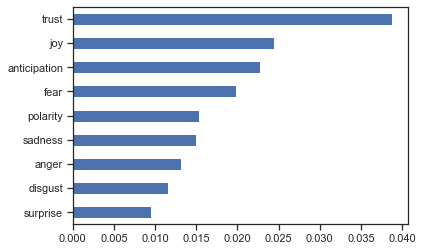

In [908]:
LETTERS[emo_cols].mean().sort_values().plot.barh()

<AxesSubplot:>

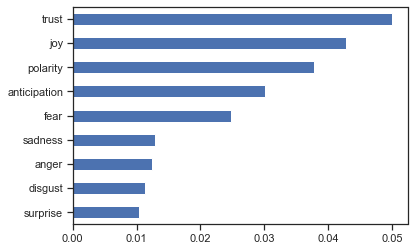

In [891]:
RELIGIOUS[emo_cols].mean().sort_values().plot.barh()

<AxesSubplot:>

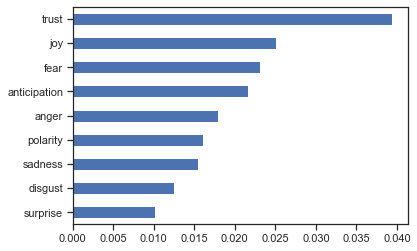

In [892]:
EVIDENCES[emo_cols].mean().sort_values().plot.barh()

<AxesSubplot:>

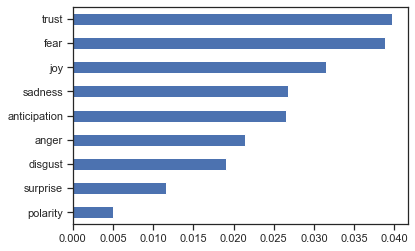

In [893]:
PROBLEM[emo_cols].mean().sort_values().plot.barh()

<AxesSubplot:>

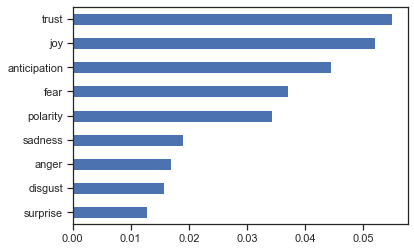

In [894]:
DON[emo_cols].mean().sort_values().plot.barh()

<AxesSubplot:>

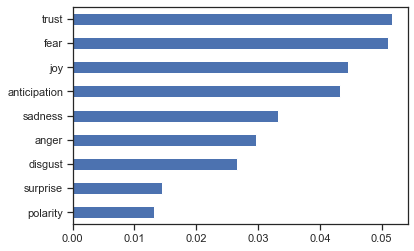

In [895]:
FIFTY[emo_cols].mean().sort_values().plot.barh()

### Sentiment by Chapter

In [909]:
LETTERS_chaps = LETTERS.groupby(CHAPS)[emo_cols].mean()
FIFTY_chaps = FIFTY.groupby(CHAPS)[emo_cols].mean()

In [910]:
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

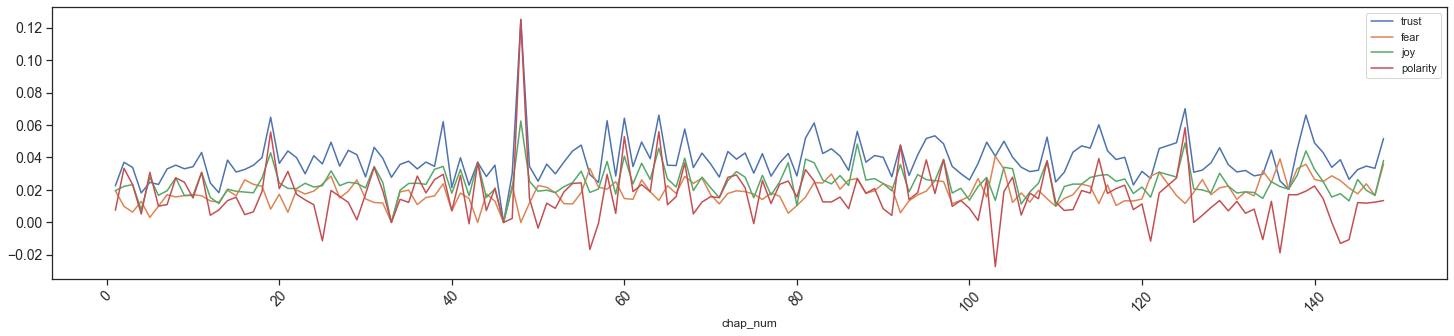

In [911]:
plot_sentiments(LETTERS_chaps, ['trust','fear','joy','polarity'])

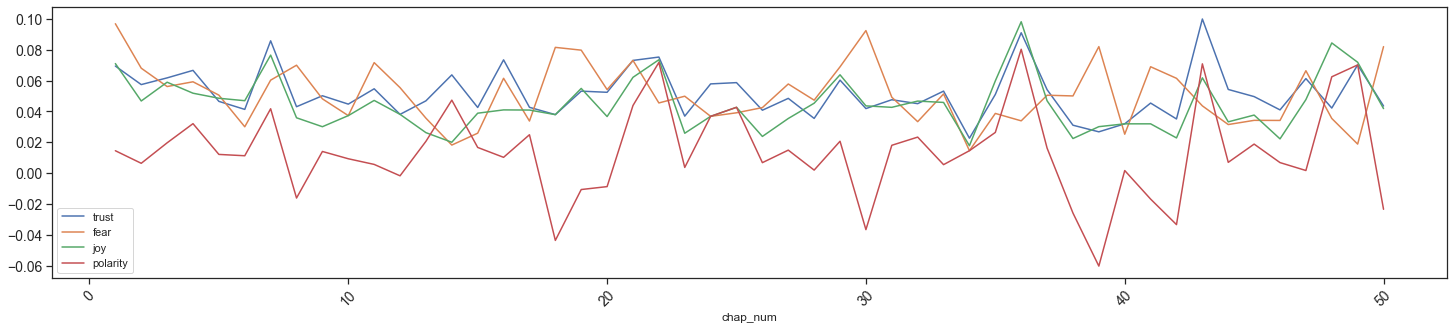

In [912]:
plot_sentiments(FIFTY_chaps, ['trust','fear','joy','polarity'])

### Explore Sentiment in Texts

In [920]:
LETTERS['html'] =  LETTERS.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
INSTITUTES['html'] =  INSTITUTES.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
PILGRIM['html'] =  PILGRIM.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
HOLY['html'] =  HOLY.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
RELIGIOUS['html'] =  RELIGIOUS.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
SELECT['html'] =  SELECT.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
EVIDENCES['html'] =  EVIDENCES.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
OUTLINES['html'] =  OUTLINES.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
PROBLEM['html'] =  PROBLEM.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
FOUR['html'] =  FOUR.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
DON['html'] =  DON.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
FIFTY['html'] =  FIFTY.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [921]:
LETTERS['html'].sample(10)

chap_num  para_num  sent_num
135       6         2            <span class='sent0'>called</span>
124       3         6           <span class='sent0'>writing</span>
59        3         8             <span class='sent0'>shall</span>
109       4         9              <span class='sent0'>from</span>
143       3         15             <span class='sent0'>time</span>
120       10        1               <span class='sent0'>the</span>
88        0         1              <span class='sent0'>then</span>
141       5         1            <span class='sent0'>course</span>
121       3         27          <span class='sent1'>patient</span>
98        3         7              <span class='sent0'>Then</span>
Name: html, dtype: object

In [924]:
LETTERS_sents = LETTERS.groupby(SENTS)[emo_cols].mean()
LETTERS_sents['sent_str'] = LETTERS.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
LETTERS_sents['html_str'] = LETTERS.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))



In [925]:
def sample_sentences(df):
    rows = []
    for idx in df.sample(10).index:

        valence = round(df.loc[idx, emo], 4)     
        t = 0
        if valence > t: color = '#ccffcc'
        elif valence < t: color = '#ffcccc'
        else: color = '#f2f2f2'
        z=0
        rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
        <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
        </tr>""".format(color, valence, df.loc[idx, 'html_str'], idx))

    display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
    display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

In [926]:
sample_sentences(LETTERS_sents)

Sentiment,ID,Sentence
0.0417,"(112, 4, 2)",This is the first day of his meeting with the states of the country to consult about setting up an order and policy in the Church I mean for their resolving and carrying into execution that which shall have been agreed for the formula is already drawn up
0.0882,"(49, 3, 17)",Thereupon without further parley I sent my brother with a certain respectable man to escort hither another who if she answers her repute will bring a dowry large enough without any money at all
0.0417,"(73, 2, 3)",So far as I could understand if we could be content with only a half Christ we might easily come to understand one another
0.0,"(105, 7, 1)",Robertson _Hist
0.0,"(51, 5, 9)",200 Since the Emperor neither understands the Latin language nor the German it has been thought best to send it written in French
0.1429,"(67, 3, 29)",Adieu my very dear brother may the Lord Jesus by his own Spirit prepare and confirm you in every good work
0.0588,"(44, 2, 13)",But who can suppose otherwise than that you have recommended him on the certificate of the Church
0.0,"(77, 6, 6)",Yours
0.0,"(71, 2, 8)",My choice would have been to excuse myself if my conscience had suffered me although I have sought to be excused when it was too late but at last it was not possible to decline
-0.0303,"(106, 2, 14)",Without any difficulty I have got what I asked for and from what I understand those who have been the means of raising this question have been sharply taken to task about it


# VADER

In [927]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [928]:
LETTERS_vader_cols = LETTERS_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
LETTERS_vader = pd.concat([LETTERS_sents, LETTERS_vader_cols], axis=1)

In [929]:
LETTERS_vader.head()

anger  anticipation  disgust  fear       joy  \
chap_num para_num sent_num                                                 
1        0        0           0.0      0.076923      0.0   0.0  0.000000   
                  1           0.0      0.043478      0.0   0.0  0.021739   
                  2           0.0      0.033333      0.0   0.0  0.033333   
                  3           0.0      0.000000      0.0   0.0  0.000000   
                  4           0.0      0.000000      0.0   0.0  0.000000   

                            sadness  surprise     trust  polarity  \
chap_num para_num sent_num                                          
1        0        0             0.0  0.000000  0.000000  0.076923   
                  1             0.0  0.000000  0.000000  0.043478   
                  2             0.0  0.033333  0.033333  0.066667   
                  3             0.0  0.000000  0.000000  0.000000   
                  4             0.0  0.000000  0.000000  0.000000   

                                                                     sent_str  \
chap_num para_num sent_num                                                      
1        0        0         13 this letter is the earliest in the series o...   
                  1         born at noyon the 10th of july 1509 educated i...   
                  2         in the first mentioned of these towns he had f...   
                  3         nicolas duchemin was of this number to whom at...   
                  4         that letter was translated into english london...   

                                                                     html_str  \
chap_num para_num sent_num                                                      
1        0        0         <span class='sent0'>13</span> <span class='sen...   
                  1         <span class='sent0'>Born</span> <span class='s...   
                  2         <span class='sent0'>In</span> <span class='sen...   
                  3         <span class='sent0'>Nicolas</span> <span class...   
                  4         <span class='sent0'>That</span> <span class='s...   

                            neg    neu    pos  compound  
chap_num para_num sent_num                               
1        0        0         0.0  1.000  0.000    0.0000  
                  1         0.0  0.924  0.076    0.5719  
                  2         0.0  0.903  0.097    0.4767  
                  3         0.0  0.788  0.212    0.6678  
                  4         0.0  1.000  0.000    0.0000

<AxesSubplot:xlabel='chap_num,para_num,sent_num'>

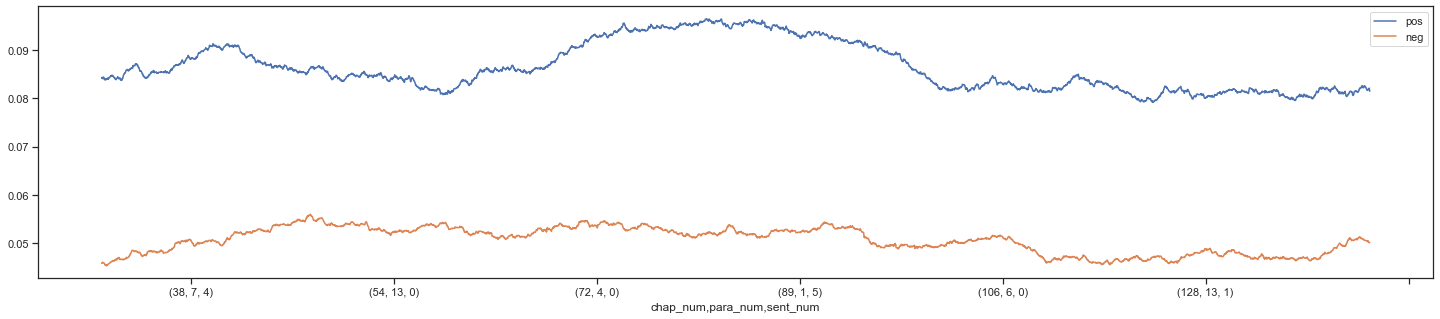

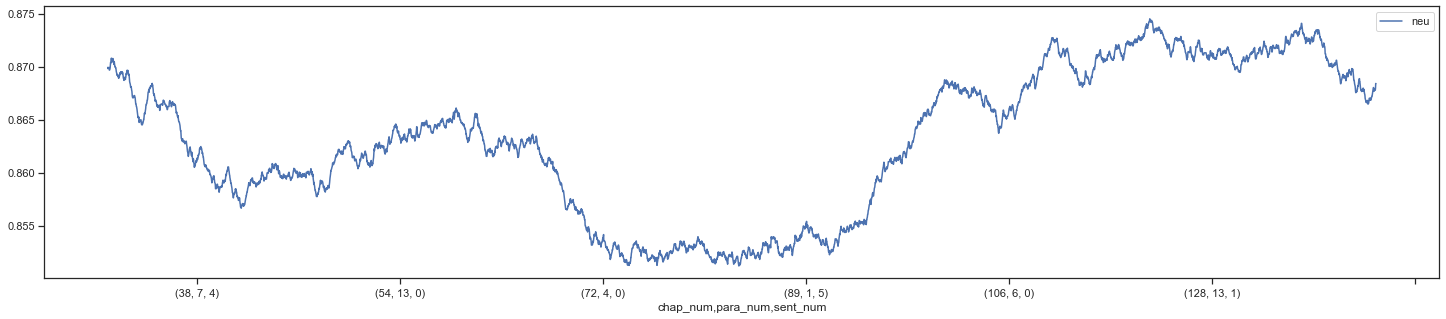

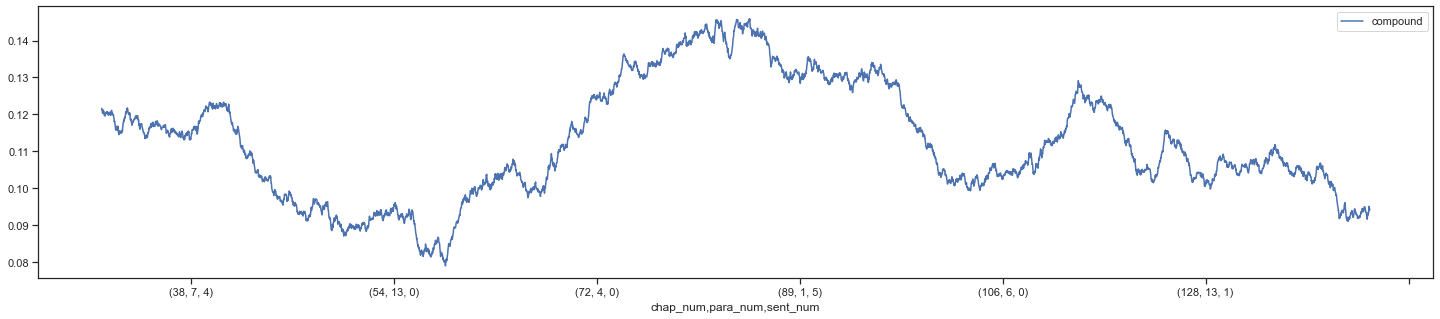

In [930]:
w = int(LETTERS_vader.shape[0] / 5)
LETTERS_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5))
LETTERS_vader[['neu']].rolling(w).mean().plot(figsize=(25,5))
LETTERS_vader[['compound']].rolling(w).mean().plot(figsize=(25,5))